In [1]:
#pip install SPARQLWrapper
#pip install wordcloud
#!pip install empath
#!pip install pycountry_convert
#!pip install geopy
#!pip install folium

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import math
import datetime as dt
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import statsmodels.formula.api as smf
from empath import Empath
from wordcloud import WordCloud

In [3]:
import warnings
warnings.filterwarnings("ignore")

# 1. Import / handling / cleaning of the data / preparation of needed dataframes for milestone 3

## 1.3 movie.metadata.tsv.gz [3.4 M] (dataset 3)


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

In [4]:
#import data
colnames = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Movie_box office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries' , 'Movie_genres'] 


movie_md_raw = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t',names = colnames, header=None)
movie_md = movie_md_raw.copy()
#rename the column
movie_md.rename(columns = {'Movie_box office_revenue':'Movie_boxoffice_revenue'}, inplace = True)
movie_md.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_boxoffice_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
59038,2137368,/m/06pk03,The Milky Way,1940,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/01z4y"": ""Comedy""}"
5774,16280949,/m/03wfxw8,Hail! Hail! Rock 'n' Roll,1987-10-09,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0d2rhq"": ""Concert film"", ""/m/0jtdp"": ""Doc..."
72708,26131098,/m/0b6nk0m,Nagarangalil Chennu Raparkam,1990,NaN,140.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/01z4y"": ""Comedy""}"
27522,8486301,/m/02754wt,Revelation,2001,NaN,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""..."
68621,24236468,/m/07k76rd,Doomsday,1990,NaN,91.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/03hkp"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama""}"


**General description of data**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Wikipedia_movie_ID       81741 non-null  int64  
 1   Freebase_movie_ID        81741 non-null  object 
 2   Movie_name               81741 non-null  object 
 3   Movie_release_date       74839 non-null  object 
 4   Movie_boxoffice_revenue  8401 non-null   float64
 5   Movie_runtime            61291 non-null  float64
 6   Movie_languages          81741 non-null  object 
 7   Movie_countries          81741 non-null  object 
 8   Movie_genres             81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


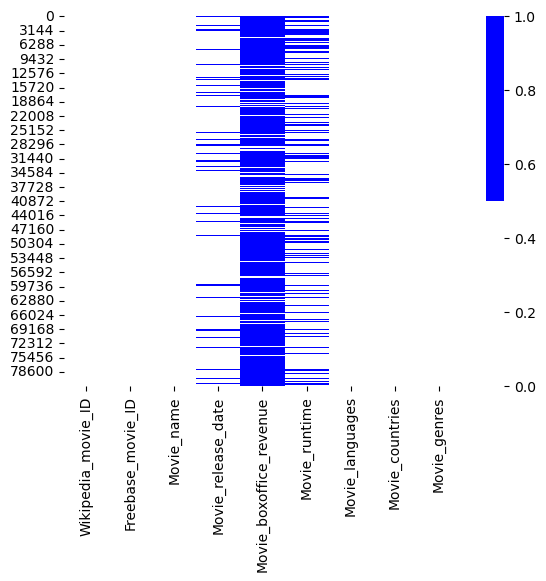

In [5]:
movie_md.info()
sns.heatmap(movie_md.isnull(), cmap=['w','b'])
plt.show()

**Create relational tables for languages, countries and genres**

In [6]:
def string2list(string):
    '''
    Converts string to dictionnary to list
    in order to be able to use pandas.DataFrame.explode()
    '''
    import ast
    
    dic = ast.literal_eval(string)
    new_list  = list(dic.values())
    return new_list


movie_languages = movie_md.copy()
movie_languages.Movie_languages = movie_languages.Movie_languages.apply(lambda x: string2list(x))
movie_languages = movie_languages.explode('Movie_languages', ignore_index = True)
movie_languages = movie_languages.drop(columns=['Freebase_movie_ID', 'Movie_name','Movie_release_date'\
                                                ,'Movie_boxoffice_revenue','Movie_runtime','Movie_countries'\
                                                ,'Movie_genres'])
movie_languages['Movie_languages']= movie_languages['Movie_languages'].astype(str) 

movie_countries = movie_md.copy()
movie_countries['Movie_countries'] = movie_countries['Movie_countries'].apply(lambda x: string2list(x))
movie_countries = movie_countries.explode('Movie_countries', ignore_index = True)
movie_countries = movie_countries.drop(columns=['Freebase_movie_ID', 'Movie_name','Movie_release_date'\
                                                ,'Movie_boxoffice_revenue','Movie_runtime','Movie_languages'\
                                                ,'Movie_genres'])

movie_genres = movie_md.copy()
movie_genres['Movie_genres'] = movie_genres['Movie_genres'].apply(lambda x: string2list(x))
movie_genres = movie_genres.explode('Movie_genres', ignore_index = True)
movie_genres = movie_genres.drop(columns=['Freebase_movie_ID', 'Movie_name','Movie_release_date'\
                                                ,'Movie_boxoffice_revenue','Movie_runtime','Movie_languages'\
                                                ,'Movie_countries'])
movie_genres

,Wikipedia_movie_ID,Movie_genres
0,975900,Thriller
1,975900,Science Fiction
2,975900,Horror
3,975900,Adventure
4,975900,Supernatural
...,...,...
245618,913762,Drama
245619,12476867,Thriller
245620,12476867,Horror
245621,12476867,Slasher


**Clean + distribution of Movie_release_date**

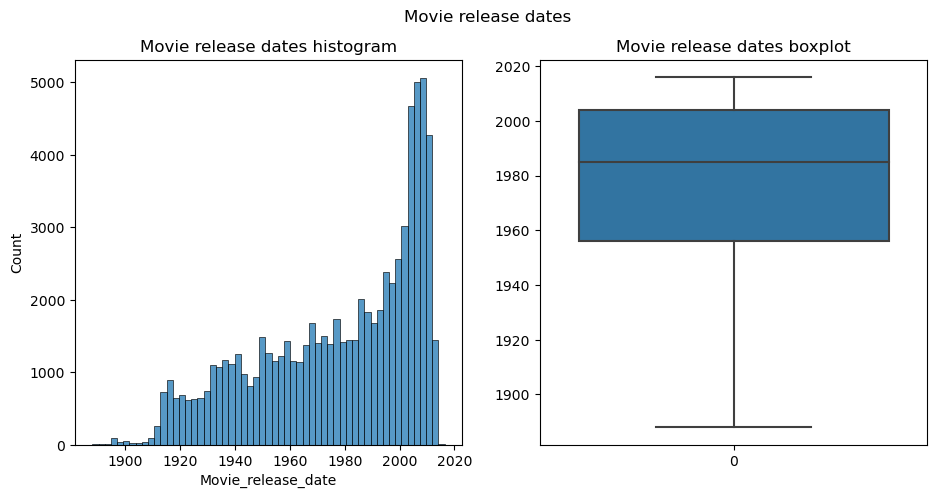

count                            74838
mean     1977-10-12 11:46:07.610037696
min                1888-01-01 00:00:00
25%                1956-01-01 00:00:00
50%                1985-05-18 12:00:00
75%                2004-01-01 00:00:00
max                2016-06-08 00:00:00
Name: Movie_release_date, dtype: object

In [7]:
#movie_md[movie_md.Movie_release_date.isna()]#all missing Movie_release_date are nan

#convert dates to datetimes. Dates with only year are set as the first of January of that year. Date that are out of bounds
#are set as NaT.
movie_md.Movie_release_date = pd.to_datetime(movie_md.Movie_release_date, errors = 'coerce', yearfirst = True)

plt.figure(figsize=[11, 5])
plt.suptitle('Movie release dates')

# Plot 1
plt.subplot(1, 2, 1)
sns.histplot(data=movie_md, x='Movie_release_date')
plt.title('Movie release dates histogram')

# Plot 2
plt.subplot(1, 2, 2)
sns.boxplot(data=movie_md.Movie_release_date.dt.year)
plt.title('Movie release dates boxplot')
plt.show()

movie_md.Movie_release_date.describe(datetime_is_numeric = True)

There doesn't seem to be any major issues with the movie release dates. Although the earliest movie from the dataset is from 1888 (which raised suspicion) and lasts only 3 seconds, after some research, it is in fact a real 'film'.

**Clean + distribution of Movie_boxoffice_revenue**

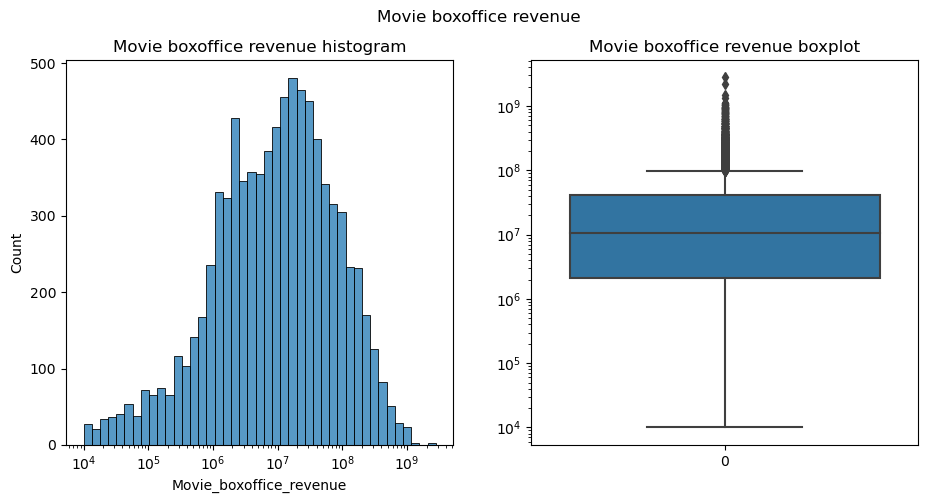

Max revenue: count    8.401000e+03
mean     4.799363e+07
std      1.121753e+08
min      1.000000e+04
25%      2.083193e+06
50%      1.063969e+07
75%      4.071696e+07
max      2.782275e+09
Name: Movie_boxoffice_revenue, dtype: float64


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_boxoffice_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


In [8]:
#movie_md[movie_md.Movie_boxoffice_revenue.isna()]#all missing Movie_release_date are nan

plt.figure(figsize=[11, 5])
plt.suptitle('Movie boxoffice revenue')

# Plot 1
plt.subplot(1, 2, 1)
sns.histplot(data=movie_md, x='Movie_boxoffice_revenue',log_scale = True)
plt.title('Movie boxoffice revenue histogram')

# Plot 2
plt.subplot(1, 2, 2)
sns.boxplot(data=movie_md.Movie_boxoffice_revenue)
plt.yscale('log')
plt.title('Movie boxoffice revenue boxplot')
plt.show()

stats = movie_md.Movie_boxoffice_revenue.describe()
print(f'Max revenue: {stats}')
movie_md.loc[movie_md.Movie_boxoffice_revenue == stats[7]]#highest movie boxoffice is real, not 'dirty data' 

**Clean + distribution of Movie_runtime**

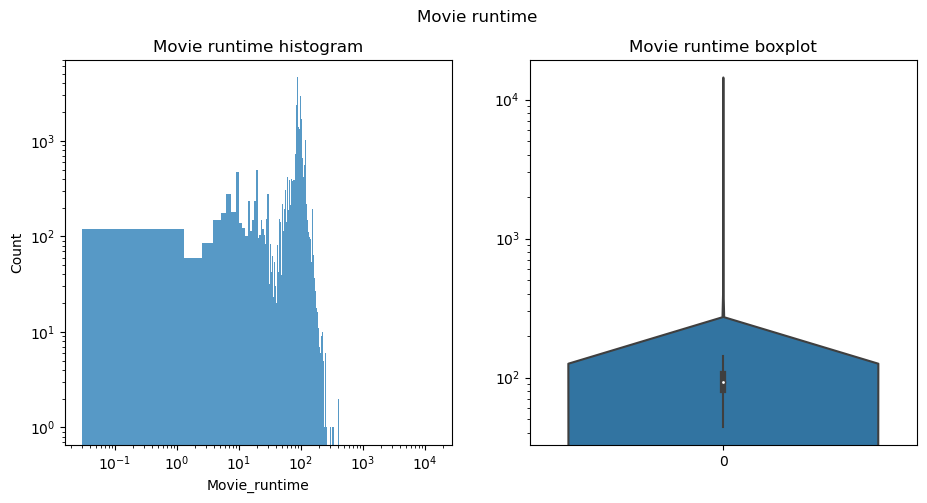

count    61289.000000
mean        94.213130
std         91.297088
min          0.030000
25%         81.000000
50%         93.000000
75%        106.000000
max      14400.000000
Name: Movie_runtime, dtype: float64

In [9]:
#movie_md[movie_md.Movie_runtime.isna()]#all missing Movie_release_date are nan

#replace the max and min movie runtime which are wrong values.
movie_md.loc[movie_md.Movie_runtime == np.max(movie_md.Movie_runtime), 'Movie_runtime'] = np.nan #wrong max 
movie_md.loc[movie_md.Movie_runtime == np.min(movie_md.Movie_runtime), 'Movie_runtime'] = np.nan #wrong min

plt.figure(figsize=[11, 5])
plt.suptitle('Movie runtime')

# Plot 1
plt.subplot(1, 2, 1)
sns.histplot(data=movie_md, x='Movie_runtime')
plt.yscale('log')
plt.xscale('log')
plt.title('Movie runtime histogram')

# Plot 2
plt.subplot(1, 2, 2)
sns.violinplot(data=movie_md.Movie_runtime)
plt.yscale('log')
plt.title('Movie runtime boxplot')
plt.show()

movie_md.Movie_runtime.describe()

stats = movie_md.Movie_runtime.describe()
stats

**Clean + distributions of movie_languages**

In [10]:
#One problematic false movie language:'\ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32' that still
#has to be dealt with. The lines below are just some tests that were done to try an resolve the issue, without success

#unique = pd.DataFrame(movie_languages.Movie_languages.unique())
#unique.sample(60)
#From the line above, problematic language value: \ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32
#unique[unique == 'English Language']
#unique[unique[0] == '\ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32']
#'utf-8' codec can't encode characters in position 97-108: surrogates not allowed
#oui = unique == '\ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32'

#non = oui[0].tolist()
#non.index(True)
#unique.iloc[82]

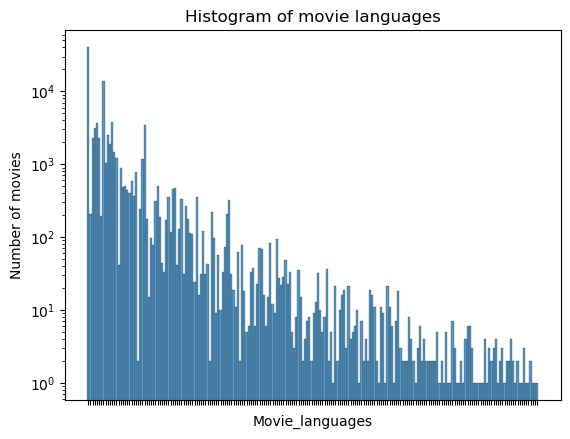

,Number_movies,Ratio,Cumsum
Movie_languages,,,
English Language,40891,42.965368,42.965368
nan,13866,14.569411,57.534779
Hindi Language,3744,3.933930,61.468709
Spanish Language,3673,3.859328,65.328038
French Language,3422,3.595595,68.923633
...,...,...,...
Picard Language,1,0.001051,99.995797
Sunda Language,1,0.001051,99.996848
Sumerian,1,0.001051,99.997899


In [11]:
#histogram of all movie languages (without labels as unreadable otherwise)
plt.figure()
g = sns.histplot(data=movie_languages, x='Movie_languages')
g.set(xticklabels=[])
g.set_title('Histogram of movie languages')
g.set_ylabel('Number of movies')
plt.yscale('log')
plt.show()

#make sorted table of movie languages with the number of movies in that language, it's propotion relative to the other
#movies + cumulative proportion (cumsum)
number_movie_languages_sorted = movie_languages.groupby(by = 'Movie_languages').count().sort_values(
                                                            by = 'Wikipedia_movie_ID', ascending = False)
number_movie_languages_sorted = number_movie_languages_sorted.rename(columns = {'Wikipedia_movie_ID': 'Number_movies'})
tot_movies_languages = number_movie_languages_sorted.sum()
number_movie_languages_sorted['Ratio'] = number_movie_languages_sorted*100/tot_movies_languages
number_movie_languages_sorted['Cumsum'] = number_movie_languages_sorted['Ratio'].cumsum()

number_movie_languages_sorted

**Clean + distributions of movie_countries**

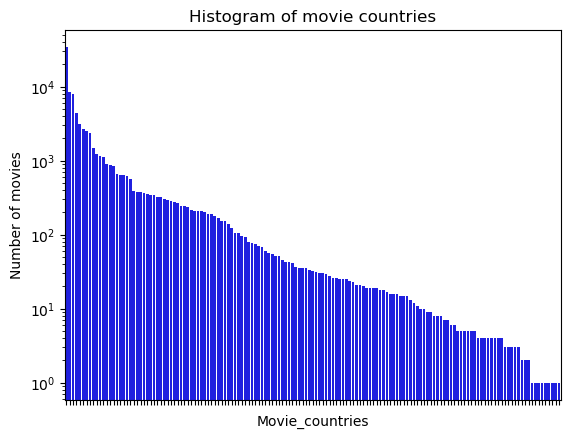

,Number_movies,Ratio,Cumsum
Movie_countries,,,
United States of America,34408,39.806106,39.806106
India,8411,9.730561,49.536667
United Kingdom,7868,9.102373,58.639040
France,4395,5.084510,63.723551
Italy,3163,3.659228,67.382779
...,...,...,...
Ukranian SSR,1,0.001157,99.995372
Iraqi Kurdistan,1,0.001157,99.996529
Macau,1,0.001157,99.997686


In [12]:
movie_countries.Movie_countries.unique()

#make sorted table of movie countires with the number of movies from that country, it's propotion relative to the other
#movies + cumulative proportion (cumsum)
number_movie_countries_sorted = movie_countries.groupby(by = 'Movie_countries').count().sort_values(
                                                            by = 'Wikipedia_movie_ID', ascending = False)
number_movie_countries_sorted = number_movie_countries_sorted.rename(columns = {'Wikipedia_movie_ID': 'Number_movies'})
tot_movies_countries = number_movie_countries_sorted.sum()

number_movie_countries_sorted['Ratio'] = number_movie_countries_sorted*100/tot_movies_countries
number_movie_countries_sorted['Cumsum'] = number_movie_countries_sorted['Ratio'].cumsum()

#barplot of all movie countries (without labels as unreadable otherwise)
plt.figure()
g = sns.barplot(data = number_movie_countries_sorted, x = number_movie_countries_sorted.index , y = 'Number_movies', color = 'b')
g.set(xticklabels=[])
g.set_title('Histogram of movie countries')
g.set_ylabel('Number of movies')
plt.yscale('log')
plt.show()

number_movie_countries_sorted

**Clean + distributions of movie_genres**

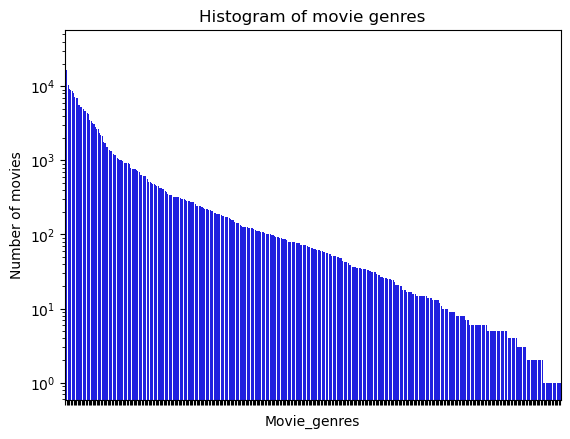

,Number_movies,Ratio,Cumsum
Movie_genres,,,
Drama,34007,13.975728,13.975728
Comedy,16349,6.718887,20.694615
Romance Film,10234,4.205828,24.900443
Black-and-white,9094,3.737327,28.637770
Action,8798,3.615681,32.253451
...,...,...,...
Comdedy,1,0.000411,99.998356
New Queer Cinema,1,0.000411,99.998767
Linguistics,1,0.000411,99.999178


In [13]:
movie_genres.Movie_genres.unique()

#replace Biopic [feature] by Biopic
movie_genres.loc[movie_genres.Movie_genres == 'Biopic [feature]','Movie_genres'] = 'Biopic'

#make sorted table of movie genres with the number of movies from that genre, it's propotion relative to the other
#movies + cumulative proportion (cumsum)
number_movie_genres_sorted = movie_genres.groupby(by = 'Movie_genres').count().sort_values(
                                                            by = 'Wikipedia_movie_ID', ascending = False)
number_movie_genres_sorted = number_movie_genres_sorted.rename(columns = {'Wikipedia_movie_ID': 'Number_movies'})
tot_movies_genres = number_movie_genres_sorted.sum()

number_movie_genres_sorted['Ratio'] = number_movie_genres_sorted*100/tot_movies_genres
number_movie_genres_sorted['Cumsum'] = number_movie_genres_sorted['Ratio'].cumsum()

#histogram of all movie genres (without labels as unreadable otherwise)
plt.figure()
g = sns.barplot(data = number_movie_genres_sorted, x = number_movie_genres_sorted.index , y = 'Number_movies', color = 'b')
g.set(xticklabels=[])
plt.yscale('log')
g.set_title('Histogram of movie genres')
g.set_ylabel('Number of movies')
plt.show()

#Display dataframe
number_movie_genres_sorted

## 1.4 character.metadata.tsv.gz (dataset 4)

Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [14]:
#Import dataset
colnames=['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name','Actor_date_of_birth', 'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID'] 

character_md = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t',names = colnames, header=None)
character_md.head(5)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Data cleaning

In [15]:
#Have an idea about the type of data
character_md.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia_movie_ID               450669 non-null  int64  
 1   Freebase_movie_ID                450669 non-null  object 
 2   Movie_release_date               440674 non-null  object 
 3   Character_name                   192794 non-null  object 
 4   Actor_date_of_birth              344524 non-null  object 
 5   Actor_gender                     405060 non-null  object 
 6   Actor_height                     154824 non-null  float64
 7   Actor_ethnicity                  106058 non-null  object 
 8   Actor_name                       449441 non-null  object 
 9   Actor_age_at_movie_release       292556 non-null  float64
 10  Freebase_character/actor_map_ID  450669 non-null  object 
 11  Freebase_character_ID            192804 non-null  object 
 12  Fr

<AxesSubplot:>

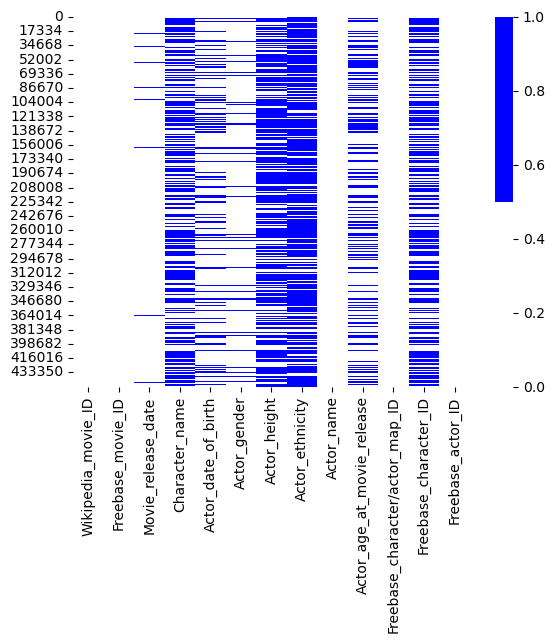

In [16]:
#Heatmap to see the presence of NaN
sns.heatmap(character_md.isnull(),cmap=['w','b'])

For some columns, such as "Wikipedia_movie_ID", "Freebase_movie_ID", "Actor_name", and "Freebase_character/actor_map_ID", and "Freebase_actor_ID", there are no NaN values (or too little). Whereas for other columns, such as "Actor_ethnicity", it seems that there more missing values than proper information.

In [17]:
#See quantitatively the number of NaN per column
print(f'There are {len(character_md)} rows')
for i in range(0,len(character_md.columns)):
    nans = character_md.iloc[:,i].isnull().sum()
    print(f'Column {character_md.columns[i]} has: \n\t {nans} NaNs \n \t {nans/len(character_md)*100}% of the rows with NaN\n')

There are 450669 rows
Column Wikipedia_movie_ID has: 
	 0 NaNs 
 	 0.0% of the rows with NaN

Column Freebase_movie_ID has: 
	 0 NaNs 
 	 0.0% of the rows with NaN

Column Movie_release_date has: 
	 9995 NaNs 
 	 2.217813961022391% of the rows with NaN

Column Character_name has: 
	 257875 NaNs 
 	 57.22048776374679% of the rows with NaN

Column Actor_date_of_birth has: 
	 106145 NaNs 
 	 23.552762670607475% of the rows with NaN

Column Actor_gender has: 
	 45609 NaNs 
 	 10.120287838746398% of the rows with NaN

Column Actor_height has: 
	 295845 NaNs 
 	 65.64573999986688% of the rows with NaN

Column Actor_ethnicity has: 
	 344611 NaNs 
 	 76.46654196317031% of the rows with NaN

Column Actor_name has: 
	 1228 NaNs 
 	 0.2724837963117055% of the rows with NaN

Column Actor_age_at_movie_release has: 
	 158113 NaNs 
 	 35.08406391387027% of the rows with NaN

Column Freebase_character/actor_map_ID has: 
	 0 NaNs 
 	 0.0% of the rows with NaN

Column Freebase_character_ID has: 
	 25786

We see indeed that 76.46654196317031% of the rows of "Actor_ethnicity" have NaN.

For the gender analysis, we create a dataset that discards rows containing NaN for 'Actor_gender' 

In [18]:
character_md_gender = character_md[character_md['Actor_gender'].notna()]
print(f'{character_md.iloc[:,5].isnull().sum()} rows are discarded.\n This corresponds to {character_md.iloc[:,5].isnull().sum()/len(character_md)*100}% of the rows')

45609 rows are discarded.
 This corresponds to 10.120287838746398% of the rows


In [19]:
#create a copy of character_md_gender, that will be used in the analysis
character_gender = character_md_gender.copy()

character_gender.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Some numbers and statistics

In [20]:
nb_women = character_gender[character_gender.Actor_gender == 'F'].shape[0]
nb_women
print(f'{nb_women/len(character_gender)*100}% of all the actors of the dataset are women')

33.27976102305831% of all the actors of the dataset are women


In [21]:
#convert the column 'Movie_release_date' from object to datetime type
character_gender['Movie_release_date'] = pd.to_datetime(character_gender['Movie_release_date'], errors = 'coerce')

In [22]:
character_gender.dtypes

Wikipedia_movie_ID                          int64
Freebase_movie_ID                          object
Movie_release_date                 datetime64[ns]
Character_name                             object
Actor_date_of_birth                        object
Actor_gender                               object
Actor_height                              float64
Actor_ethnicity                            object
Actor_name                                 object
Actor_age_at_movie_release                float64
Freebase_character/actor_map_ID            object
Freebase_character_ID                      object
Freebase_actor_ID                          object
dtype: object

In [23]:
#create new column containing only the year: Movie_year
character_gender['Movie_year'] = character_gender['Movie_release_date'].dt.year
character_gender.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0


Text(0, 0.5, 'Number of actors/actresses')

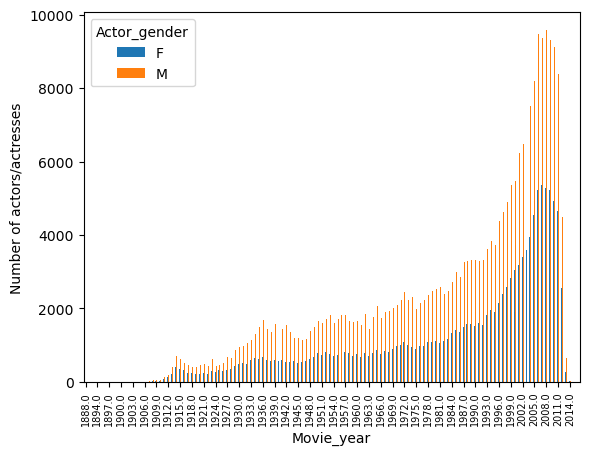

In [24]:
#Plot histogram of number of actor and actresses per year
character_gender.pivot_table(index=['Movie_year'],columns='Actor_gender',aggfunc='size').plot(kind='bar')
ax = plt.gca()
ax.set_xticks(ax.get_xticks()[::3])
ax.xaxis.set_tick_params(labelsize=7)
ax.set_ylabel('Number of actors/actresses')

We can clearly see that the number of men cast per year surpasses the number of women for almost all the years

## 1.5 tvtropes.clusters.txt (dataset 5)

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

First of all, the text document is read into a dataframe with tabstop as separator. Further manipulations are performed in order to have a well-arranged dataframe including all necessary information.

In [25]:
# create dataframe by reading the textfile with tabstop as separator
colnames = ['character_type', 'description'] 

df_tvtropes = pd.read_csv('data/MovieSummaries/tvtropes.clusters.txt',
                          names = colnames, header = None, sep="\t", on_bad_lines='warn')

In [26]:
# split column "description" of the df in further columns "char", "movie", "id", and "actor"
df_tvtropes.description=df_tvtropes['description'].str.replace("{" ,"",regex=True)
df_tvtropes.description=df_tvtropes['description'].str.replace("}" ,"",regex=True)

# new data frame with split value columns
new = df_tvtropes["description"].str.split('", "|": "', expand=True)
 
# add to existing dataframe
df_tvtropes["char"]= new[1]
df_tvtropes["movie"]= new[3]
df_tvtropes["id"]=new[5]
df_tvtropes["actor"]=new[7]

df_tvtropes['actor']=df_tvtropes['actor'].str.replace('"' ,'',regex=True)
 
# Drop old column "description"
df_tvtropes.drop(columns =["description"], inplace = True)

# Merge with Character Metadata to get gender of actor
df_tvtropes = pd.merge(df_tvtropes, character_md[['Freebase_character/actor_map_ID','Actor_gender']],
                       left_on='id', right_on='Freebase_character/actor_map_ID', how='left')

# create column with release year only
#df_tvtropes['Movie_release_date'] = pd.to_datetime(df_tvtropes['Movie_release_date'], errors = 'coerce')
#df_tvtropes['Movie_year'] = df_tvtropes['Movie_release_date'].dt.year.fillna(0.0).astype(int)
  
# display df
df_tvtropes

,character_type,char,movie,id,actor,Freebase_character/actor_map_ID,Actor_gender
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,/m/0jy9q0,M
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,/m/02vchl3,M
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,/m/0k6fkc,M
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,/m/0k6_br,M
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,/m/0k3rhh,M
...,...,...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton,/m/0k776f,M
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson,/m/0k2kqg,M
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West,/m/0k5nsh,M
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez,/m/03lrjk0,M


In [27]:
# check if there is any NaN value
df_tvtropes.isnull().any()

character_type                     False
char                               False
movie                              False
id                                 False
actor                              False
Freebase_character/actor_map_ID    False
Actor_gender                        True
dtype: bool

The dataframe is grouped by character types in order to investigate the most prevalent types.

In [28]:
df_tvtropes_grouped = df_tvtropes.groupby(['character_type'])['character_type'].count().\
                        to_frame(name='nb_movies').reset_index()
df_tvtropes_grouped = df_tvtropes_grouped.sort_values(by='nb_movies', ascending=False).reset_index()
df_tvtropes_grouped.drop(columns =["index"], inplace = True)

In [29]:
print('These are the 10 most prevalent character types:')
for i in range(10):
    print(f"{i+1}. {df_tvtropes_grouped['character_type'][i]} (in {df_tvtropes_grouped['nb_movies'][i]} movies)")

These are the 10 most prevalent character types:
1. crazy_jealous_guy (in 25 movies)
2. corrupt_corporate_executive (in 23 movies)
3. byronic_hero (in 17 movies)
4. psycho_for_hire (in 16 movies)
5. father_to_his_men (in 15 movies)
6. stoner (in 13 movies)
7. brainless_beauty (in 12 movies)
8. master_swordsman (in 12 movies)
9. dumb_blonde (in 11 movies)
10. slacker (in 11 movies)


For the analysis, the dataframe is divided into two dataframes. One conains all instances with a woman as an actress, the other one with men.

In [30]:
# create separate dfs by gender
df_tvtropes_M = df_tvtropes[df_tvtropes['Actor_gender']=='M']
df_tvtropes_F = df_tvtropes[df_tvtropes['Actor_gender']=='F']
print(f'Number of tvtropes for a female actor: {df_tvtropes_F.shape[0]}')
print(f'Number of tvtropes for a male actor: {df_tvtropes_M.shape[0]}')
print(f"Number of tvtropes where gender of actor/actress could not be identified:\
 {df_tvtropes[df_tvtropes['Actor_gender'].isnull()].shape[0]} -> this instance will not be considered for further analysis")

Number of tvtropes for a female actor: 69
Number of tvtropes for a male actor: 431
Number of tvtropes where gender of actor/actress could not be identified: 1 -> this instance will not be considered for further analysis


# Part 1 - Gender inequality in the movie industry - Preparation of dataframes for further analysis

## Question 1.1

In [30]:
#Look at the dataframe that will be used to create other dataframes in this section
character_gender.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0


**Number of males and females in each movie**

In [31]:
#We want to get a dataframe with one movie per row, showing its year, nb of men, nb of women, 
#and female share (nb_women/(nb_men+nb_women))

#Do a copy of character_gender, so that the copy can be used to create grouped versions
grouped_gender = character_gender.copy()

#Select columns of interest
grouped_gender = grouped_gender[['Wikipedia_movie_ID','Actor_gender', 'Movie_year']]

#Count the number of female/male actors for each movie (group per movie)
#this is done by creating two new dataframes (for F and M)
grouped_gender_F = grouped_gender.loc[grouped_gender.Actor_gender == 'F']
grouped_gender_F_movie = grouped_gender_F.groupby(['Wikipedia_movie_ID','Movie_year']).count()
grouped_gender_F_movie = grouped_gender_F_movie.rename(columns = {'Actor_gender':'Female'}).sort_values(by = 'Movie_year')

grouped_gender_M = grouped_gender.loc[grouped_gender.Actor_gender == 'M']
grouped_gender_M_movie = grouped_gender_M.groupby(['Wikipedia_movie_ID','Movie_year']).count()
grouped_gender_M_movie = grouped_gender_M_movie.rename(columns = {'Actor_gender':'Male'}).sort_values(by = 'Movie_year')

#Merge the two dataframes with number of males and females for each movie
grouped_gender_movie = pd.merge(grouped_gender_F_movie, grouped_gender_M_movie, on = ['Wikipedia_movie_ID', 'Movie_year'], how = 'outer')
grouped_gender_movie = grouped_gender_movie.fillna(0)

#Create Female_share: metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_movie['Female_share'] = grouped_gender_movie.Female/(grouped_gender_movie.Female + grouped_gender_movie.Male)
grouped_gender_movie = grouped_gender_movie.reset_index()
grouped_gender_movie.head(5)


,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share
0,1082508,1888.0,2.0,2.0,0.5
1,7669437,1894.0,1.0,0.0,1.0
2,807258,1896.0,3.0,0.0,1.0
3,4062042,1896.0,1.0,1.0,0.5
4,436308,1896.0,1.0,1.0,0.5


**Number of males and females cast per year**

In [32]:
#Here, we are no longer interested in each movie individually, but in the Female_share per year
#reset grouped_gender
grouped_gender = character_gender.copy()
#Select columns of interest:
grouped_gender = grouped_gender[['Actor_gender', 'Movie_year']]


#Do the same procedure as before, this time grouping by year instead of movie
#Count the number of female/male actors for each year
grouped_gender_F = grouped_gender.loc[grouped_gender.Actor_gender == 'F']
grouped_gender_F_year = grouped_gender_F.groupby(['Movie_year']).count()
grouped_gender_F_year = grouped_gender_F_year.rename(columns = {'Actor_gender':'Female'})

grouped_gender_M = grouped_gender.loc[grouped_gender.Actor_gender == 'M']
grouped_gender_M_year = grouped_gender_M.groupby(['Movie_year']).count()
grouped_gender_M_year = grouped_gender_M_year.rename(columns = {'Actor_gender':'Male'})

#Merge the number of males and females for each year
grouped_gender_year = pd.merge(grouped_gender_F_year, grouped_gender_M_year, on = ['Movie_year'], how = 'outer')
grouped_gender_year = grouped_gender_year.fillna(0)
grouped_gender_year = grouped_gender_year.sort_index()

#Create Female_share, metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_year['Female_share'] = grouped_gender_year.Female/(grouped_gender_year.Female + grouped_gender_year.Male)
grouped_gender_year = grouped_gender_year.reset_index()

grouped_gender_year

,Movie_year,Female,Male,Female_share
0,1888.0,2.0,2,0.500000
1,1891.0,0.0,1,0.000000
2,1893.0,0.0,2,0.000000
3,1894.0,1.0,3,0.250000
4,1895.0,0.0,1,0.000000
...,...,...,...,...
121,2012.0,2545.0,4502,0.361147
122,2013.0,281.0,643,0.304113
123,2014.0,15.0,21,0.416667
124,2015.0,2.0,12,0.142857


## Question 1.2

**Calculate female share per country**

In [33]:
#Now, we are interested in the Female_share per country:
#we will group by country, with the same procedure as before
grouped_gender = character_gender.copy()
grouped_gender = grouped_gender[['Wikipedia_movie_ID','Actor_gender','Movie_year']]

In [34]:
#merge grouped_gender with the dataset containing countries (movie_countries), created at the data cleaning of dataset 3
#using movie_ID as common attribute
grouped_gender_country = pd.merge(grouped_gender, movie_countries, on = ['Wikipedia_movie_ID'], how = 'outer')
grouped_gender_country.head()

,Wikipedia_movie_ID,Actor_gender,Movie_year,Movie_countries
0,975900,F,2001.0,United States of America
1,975900,F,2001.0,United States of America
2,975900,M,2001.0,United States of America
3,975900,M,2001.0,United States of America
4,975900,F,2001.0,United States of America


In [35]:
del grouped_gender_country['Wikipedia_movie_ID'], grouped_gender_country['Movie_year']

#Count the number of female/male actors for each country
grouped_gender_F = grouped_gender_country.loc[grouped_gender_country.Actor_gender == 'F']
grouped_gender_F_country = grouped_gender_F.groupby(['Movie_countries']).count()
grouped_gender_F_country = grouped_gender_F_country.rename(columns = {'Actor_gender':'Female'})

grouped_gender_M = grouped_gender_country.loc[grouped_gender_country.Actor_gender == 'M']
grouped_gender_M_country = grouped_gender_M.groupby(['Movie_countries']).count()
grouped_gender_M_country = grouped_gender_M_country.rename(columns = {'Actor_gender':'Male'})

#Merge the number of males and females for each country
grouped_gender_country = pd.merge(grouped_gender_F_country, grouped_gender_M_country, on = ['Movie_countries'], how = 'outer')
grouped_gender_country = grouped_gender_country.fillna(0)

#Create metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_country['Female_share'] = grouped_gender_country.Female/(grouped_gender_country.Female + grouped_gender_country.Male)

In [36]:
grouped_gender_country=grouped_gender_country.reset_index()
grouped_gender_country.head()

,Movie_countries,Female,Male,Female_share
0,Afghanistan,23.0,34.0,0.403509
1,Albania,17.0,46.0,0.269841
2,Algeria,32.0,89.0,0.264463
3,Argentina,797.0,1503.0,0.346522
4,Armenia,8.0,11.0,0.421053


**Plot countries on a map with Female_share**

We want to show on a map what is the Female_share for the top 10 movie-producing countries. For this, two functions are created: one to obtain the country code and another to get latitute and latitute of the country.

In [37]:
#function to convert to alpah2 country codes and continents
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_continent)

In [38]:
#function to get longitude and latitude data from country name
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

In [39]:
#select top 10 movie-producing countries from a dataset created in cleaning, part 1.3
top_10 = number_movie_countries_sorted.head(10).reset_index()
top_10

#Get top 4 movie-producing countries 
top_4 = top_10.Movie_countries[0:4].tolist()

In [40]:
grouped_gender_country_10 = grouped_gender_country.copy()
#We update top_10 such that it contains the Female_share for the top 10 movie-producing countries
top_10 = grouped_gender_country_10[(grouped_gender_country_10.Movie_countries.isin(top_10.Movie_countries))]
top_10

,Movie_countries,Female,Male,Female_share
3,Argentina,797.0,1503.0,0.346522
21,Canada,5476.0,9738.0,0.359932
40,France,8829.0,15547.0,0.362201
45,Germany,4984.0,10174.0,0.328803
48,Hong Kong,1973.0,4936.0,0.285570
51,India,15622.0,29872.0,0.343386
58,Italy,4700.0,9245.0,0.337038
60,Japan,4541.0,7948.0,0.363600
127,United Kingdom,15396.0,32386.0,0.322213
128,United States of America,72632.0,151461.0,0.324115


In [41]:
#Call the get_continent function, in order to find country codes
#Country codes will be required to find latitude and longitude 
top_10['Country_code']='0'
for i in range(0,len(top_10)):
    top_10.iloc[i,4]=get_continent(top_10.iloc[i,0])[0]

In [42]:
top_10

,Movie_countries,Female,Male,Female_share,Country_code
3,Argentina,797.0,1503.0,0.346522,AR
21,Canada,5476.0,9738.0,0.359932,CA
40,France,8829.0,15547.0,0.362201,FR
45,Germany,4984.0,10174.0,0.328803,DE
48,Hong Kong,1973.0,4936.0,0.285570,HK
51,India,15622.0,29872.0,0.343386,IN
58,Italy,4700.0,9245.0,0.337038,IT
60,Japan,4541.0,7948.0,0.363600,JP
127,United Kingdom,15396.0,32386.0,0.322213,GB
128,United States of America,72632.0,151461.0,0.324115,US


In [43]:
#Run the function above and split geolocate into two separate latitude and longitude columns
top_10[['Latitude','Longitude']]=[0,0]
for i in range(0,len(top_10)):
    top_10.iloc[i,5]=geolocate(top_10.iloc[i,4])[0]
    top_10.iloc[i,6]=geolocate(top_10.iloc[i,4])[1]

In [44]:
top_10.head(5)

,Movie_countries,Female,Male,Female_share,Country_code,Latitude,Longitude
3,Argentina,797.0,1503.0,0.346522,AR,-34.996496,-64.967282
21,Canada,5476.0,9738.0,0.359932,CA,61.066692,-107.991707
40,France,8829.0,15547.0,0.362201,FR,46.603354,1.888334
45,Germany,4984.0,10174.0,0.328803,DE,51.163818,10.447831
48,Hong Kong,1973.0,4936.0,0.285570,HK,22.350627,114.184916


In [45]:
# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(top_10)):
    lat = top_10.iloc[i]['Latitude']
    long = top_10.iloc[i]['Longitude']
    #Use exponential to be able to see a difference between circles
    radius=np.exp(top_10.iloc[i,3]*10)
    popup_text = """Country : {}<br>
                 Share of female in movies: {}<br>"""
    popup_text = popup_text.format(top_10.iloc[i]['Country_code'],
                                   top_10.iloc[i]['Female_share'])
    folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
#world_map
#since this map is interactive, it is, unfortunately, not possible to show it in this first milestone
#therefore, this map will be present in our final data-story
#It will be possible to zoom in, and, by clicking on the country circle, see the country code, and its share of female in movies.

## Question 1.3

**Look at Female_share per movie genres**

In [46]:
#Dataframe previously created in the cleaning part (1.3)
#It is grouped by movie_genres
number_movie_genres_sorted

,Number_movies,Ratio,Cumsum
Movie_genres,,,
Drama,34007,13.975728,13.975728
Comedy,16349,6.718887,20.694615
Romance Film,10234,4.205828,24.900443
Black-and-white,9094,3.737327,28.637770
Action,8798,3.615681,32.253451
...,...,...,...
Comdedy,1,0.000411,99.998356
New Queer Cinema,1,0.000411,99.998767
Linguistics,1,0.000411,99.999178


In [47]:
#Create a new dataframe "genres_gender" by merging movie_genres and character_gender
genres_gender = pd.merge(movie_genres, character_gender, on = ['Wikipedia_movie_ID'], how = 'outer')
genres_gender = genres_gender[['Movie_genres','Actor_gender']]
genres_gender.sample(5)

,Movie_genres,Actor_gender
766719,Chinese Movies,M
1176239,Crime Comedy,M
367707,Comedy,M
469134,Adventure,M
607063,Drama,F


In [48]:
#Same procedure done before:
#Count the number of female/male actors for each year
grouped_gender_F = genres_gender.loc[genres_gender.Actor_gender == 'F']
grouped_gender_F_genres = grouped_gender_F.groupby(['Movie_genres']).count()
grouped_gender_F_genres = grouped_gender_F_genres.rename(columns = {'Actor_gender':'Female'})

grouped_gender_M = genres_gender.loc[genres_gender.Actor_gender == 'M']
grouped_gender_M_genres = grouped_gender_M.groupby(['Movie_genres']).count()
grouped_gender_M_genres = grouped_gender_M_genres.rename(columns = {'Actor_gender':'Male'})

#Merge the number of males and females for each year
grouped_gender_genres = pd.merge(grouped_gender_F_genres, grouped_gender_M_genres, on = ['Movie_genres'], how = 'outer')
grouped_gender_genres = grouped_gender_genres.fillna(0)
grouped_gender_genres = grouped_gender_genres.sort_index()

#Create metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_genres['Female_share'] = grouped_gender_genres.Female/(grouped_gender_genres.Female + grouped_gender_genres.Male)
grouped_gender_genres = grouped_gender_genres.reset_index()

#grouped_gender_genres is a dataframe with Female_share per each movie genre
grouped_gender_genres.sort_values(by='Female_share',ascending=False).head()

,Movie_genres,Female,Male,Female_share
289,Romantic thriller,1.0,0.0,1.000000
177,Health & Fitness,12.0,6.0,0.666667
347,War effort,2.0,1.0,0.666667
352,Women in prison films,64.0,39.0,0.621359
254,Pinku eiga,44.0,28.0,0.611111


Now we create a dataframe containing one movie per row, with respective female_share and genre. This will be useful for merging all precedent datasets in Q1.5

In [49]:
#add movie genres to the dataframe "grouped_gender_movie" created at Q1.1
#this is done by merging the datframes grouped_gender_movie with movie_genres 
#(created at 1.3 of Data cleaning part)
grouped_movie_genre_gender = pd.merge(grouped_gender_movie, movie_genres, on = ['Wikipedia_movie_ID'], how = 'outer')
grouped_movie_genre_gender.head()

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_genres
0,1082508,1888.0,2.0,2.0,0.5,Short Film
1,1082508,1888.0,2.0,2.0,0.5,Silent film
2,1082508,1888.0,2.0,2.0,0.5,Indie
3,1082508,1888.0,2.0,2.0,0.5,Black-and-white
4,7669437,1894.0,1.0,0.0,1.0,Short Film


## Question 1.4

In [50]:
#Creation of dataframe to be used for question 2
actor = character_gender.copy()

#Keep only columns of interest
actor = actor[['Wikipedia_movie_ID', 'Movie_year', 'Actor_gender','Actor_ethnicity',
                                     'Actor_name', 'Actor_age_at_movie_release', 'Freebase_actor_ID']]

#Aggregate rows on actor_ID, perform various functions on the other columns
actor = actor.groupby(by = 'Freebase_actor_ID').agg({'Wikipedia_movie_ID': 'count', 
                                                     'Movie_year': 'min',
                                                     'Actor_gender' : pd.Series.mode,
                                                     'Actor_ethnicity' : pd.Series.mode,
                                                     'Actor_name' : pd.Series.mode,
                                                     'Actor_age_at_movie_release' : ['min','max']})

#Clean the dataframe: drop one level of columns and rename them. Add a career_length column
actor = actor.droplevel(level = [0], axis=1)
actor.columns = ['Movie_count', 'First_movie_year', 'Gender', 'Actor_ethnicity', 'Actor_name', 'Min_actor_age', 'Max_actor_age']
actor['Career_length'] = actor.Max_actor_age - actor.Min_actor_age + 1

#replace emply list [] (missing actor_ethnicity) with NaN
actor.Actor_ethnicity = actor.Actor_ethnicity.apply(lambda y: np.nan if len(y)==0 else y)
actor.index.is_unique

actor



,Movie_count,First_movie_year,Gender,Actor_ethnicity,Actor_name,Min_actor_age,Max_actor_age,Career_length
Freebase_actor_ID,,,,,,,,
/m/010p3,12,1998.0,M,/m/0xnvg,Adam Carolla,33.0,47.0,15.0
/m/010q36,1,1995.0,M,NaN,Fred Rogers,67.0,67.0,1.0
/m/010wx,1,2003.0,F,/m/03q819,Aria Giovanni,25.0,25.0,1.0
/m/010xjr,54,1959.0,M,/m/03bkbh,Richard Harris,28.0,72.0,45.0
/m/0112yl,48,1948.0,M,NaN,Toshiro Mifune,28.0,69.0,42.0
...,...,...,...,...,...,...,...,...
/m/0z58,1,1998.0,M,NaN,Ardal O'Hanlon,NaN,NaN,NaN
/m/0z9q0,1,2012.0,M,NaN,"José Luis Rodríguez ""El Puma""",69.0,69.0,1.0
/m/0zcb7,6,1990.0,M,NaN,Marcus Giamatti,29.0,48.0,20.0


**Retrieve ethnicity + add it to 'actor' dataframe**

In [51]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT ?item ?freebaseID ?name WHERE {
  ?item p:P646 [ps:P646 ?freebaseID]. #get the freebaseID
  ?item rdfs:label ?name.             #get the name of the enthnic group
  ?item p:P31 [ps:P31 wd:Q41710].     #get only the items whose "instance of" is "ethnic group"
  filter(lang(?name) = "en")          #get the names in english
}"""


def get_results(endpoint_url, query):
    user_agent = "ADA_silvermafia-project Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

In [52]:
l1 = []
l2 = []
for i in range(len(results['results']['bindings'])):
    v1 = results['results']['bindings'][i]['freebaseID']['value']
    v2 = results['results']['bindings'][i]['name']['value']
    l1.append(v1)
    l2.append(v2)

Ethnicities = pd.DataFrame()
Ethnicities['Freebase_ethnicity_ID'] = l1
Ethnicities['Ethnicity'] = l2
Ethnicities

,Freebase_ethnicity_ID,Ethnicity
0,/m/017_9v,Saka
1,/m/0c2xyb,Sumo people
2,/m/02rwfg,Yotvingians
3,/m/03c8vzn,Czech Canadians
4,/m/04g1jdt,Chagatai people
...,...,...
5762,/m/0138g9r_,Klingalese
5763,/m/0131y41n,Lamba people
5764,/m/04zgdz,Dwe'e people
5765,/m/0_lc6ny,Chinese Americans in New York City


This next cell is useless for the project. It is a little easter egg found in the Freebase ethnicity ID while handling the ID's. We deemed it worth sharing

In [53]:
#I wanted to find if any ID's did not start with the usual '/m/' and found this gem
easter_egg = Ethnicities.Freebase_ethnicity_ID.unique()
for i in range(len(easter_egg)):
    if easter_egg[i][0] != '/':
        print(easter_egg[i])

In [54]:
actor = pd.merge(actor, Ethnicities, left_on='Actor_ethnicity', right_on='Freebase_ethnicity_ID', how='left')
actor = actor.drop(columns = ['Actor_ethnicity', 'Freebase_ethnicity_ID'])
actor

,Movie_count,First_movie_year,Gender,Actor_name,Min_actor_age,Max_actor_age,Career_length,Ethnicity
0,12,1998.0,M,Adam Carolla,33.0,47.0,15.0,Italian Americans
1,1,1995.0,M,Fred Rogers,67.0,67.0,1.0,NaN
2,1,2003.0,F,Aria Giovanni,25.0,25.0,1.0,NaN
3,54,1959.0,M,Richard Harris,28.0,72.0,45.0,Irish people
4,48,1948.0,M,Toshiro Mifune,28.0,69.0,42.0,NaN
...,...,...,...,...,...,...,...,...
97378,1,1998.0,M,Ardal O'Hanlon,NaN,NaN,NaN,NaN
97379,1,2012.0,M,"José Luis Rodríguez ""El Puma""",69.0,69.0,1.0,NaN
97380,6,1990.0,M,Marcus Giamatti,29.0,48.0,20.0,NaN
97381,54,1992.0,M,Paul Giamatti,24.0,46.0,23.0,NaN


## Question 1.5

Here, we create the dataframe df_regression, that will merge all relevant information of movies.
The dataframe df_regression should contain the potential predictors, to be used in the regression analysis.


In [55]:
#create a new dataframe by mergin the datframes created in 1.1-1.3 on "Wikipedia_movie_ID"
df_regression = pd.merge(grouped_movie_genre_gender, movie_countries, on = ['Wikipedia_movie_ID'], how = 'outer')
df_regression = pd.merge(df_regression, grouped_gender_movie, on = ['Wikipedia_movie_ID'], how = 'outer')
df_regression = pd.merge(df_regression,movie_md, on = ['Wikipedia_movie_ID'], how = 'outer')

#Select columns of interest
df_regression = df_regression[['Wikipedia_movie_ID','Movie_year_x','Female_x','Male_x','Female_share_x','Movie_genres_x',
                               'Movie_countries_x','Movie_name','Movie_boxoffice_revenue','Movie_runtime']]
df_regression.rename(columns = {'Movie_year_x':'Movie_year','Female_x':'Female','Male_x':'Male',
                                'Female_share_x':'Female_share','Movie_genres_x':'Movie_genres',
                                'Movie_countries_x':'Movie_countries'}, inplace = True)


In [56]:
df_regression.sample(5)

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_genres,Movie_countries,Movie_name,Movie_boxoffice_revenue,Movie_runtime
267707,7818706,NaN,NaN,NaN,NaN,Comedy,United Kingdom,Dead on Time,NaN,NaN
158115,640040,2004.0,4.0,6.0,0.400000,Thriller,United States of America,10.5,NaN,165.0
223468,31665420,1929.0,0.0,1.0,0.000000,Romance Film,NaN,A Romance of Seville,NaN,NaN
159381,3048276,2004.0,2.0,7.0,0.222222,Romantic drama,United States of America,The Work and The Glory,3347647.0,118.0
216328,33454893,2012.0,1.0,0.0,1.000000,Drama,NaN,Karasu no Oyayubi,NaN,NaN


# Part 2 - Stereotypes and representation of different genders in the film industry

## Question 2.1

We now want to create a wordcloud showing the most used words for the tv tropes describing female characters as well as for male characters. To do so, the tropes need to be seperated by words.

In [57]:
#pip install wordcloud

In [31]:
words_F = ' '.join(df_tvtropes_F['character_type'].values)
words_F = words_F.replace("_"," ")

words_M = ' '.join(df_tvtropes_M['character_type'].values)
words_M = words_M.replace("_"," ")

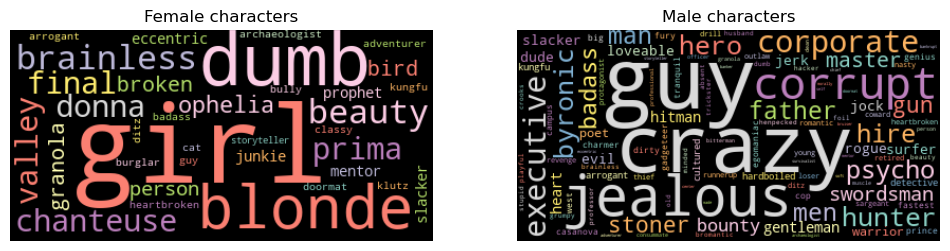

In [32]:


# Generate a word cloud image
wordcloud_F = WordCloud(collocations=False, background_color='black', colormap='Set3').generate(words_F)
wordcloud_M = WordCloud(collocations=False, background_color='black', colormap='Set3').generate(words_M)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (12,6))

ax1.imshow(wordcloud_F, interpolation="bilinear")
ax1.set_title('Female characters')
ax1.axis("off")
ax2.imshow(wordcloud_M, interpolation="bilinear")
ax2.set_title('Male characters');
ax2.axis("off");
#plt.show()

The most used words characterizing a female and a male character respectively depict pretty much the stereotypes: The beautiful, blonde and dumb girl whereas male characters are represented as corrupt, hero, badass, among other. Moreover, the most used noun for women is "girl", whereas "guy" is mostely used to represent a man.

In addition, we would like to compare these words. Therefore, we make use of the Python library "Empath" in order to categorize every word from the tv tropes into same lexical fields. Empath has predefined classes and directly assign our words to the suitable class. This allows us to directly compare the words of the two gender groups.

Use Empath to categorize words from above into lexical fields.

In [33]:
from empath import Empath
lexicon = Empath()

In [34]:
# Every word of a tv trope is considered seperately
df_category = []
df_category.append(lexicon.analyze('_'.join(df_tvtropes_F['character_type'].values).split('_'), normalize=True))
df_category.append(lexicon.analyze('_'.join(df_tvtropes_M['character_type'].values).split('_'), normalize=True))

# transform into a dataframe
df_category = pd.DataFrame(df_category, index = ['Female','Male'])  
df_category

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Female,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.008197,...,0.000000,0.098361,0.000000,0.000000,0.0,0.0,0.0,0.049180,0.0,0.0
Male,0.0,0.0,0.0,0.003018,0.012072,0.0,0.0,0.0,0.0,0.033199,...,0.013078,0.028169,0.035211,0.009054,0.0,0.0,0.0,0.007042,0.0,0.0


In [35]:
df_category = df_category.loc[:, (df_category != 0).any(axis=0)] # delete lexical field with 0 for both F and M

In [36]:
df_category = df_category.copy().T
df_category

,Female,Male
money,0.000000,0.003018
wedding,0.000000,0.012072
hate,0.008197,0.033199
occupation,0.000000,0.064386
envy,0.000000,0.025151
...,...,...
weapon,0.000000,0.013078
children,0.098361,0.028169
monster,0.000000,0.035211
ocean,0.000000,0.009054


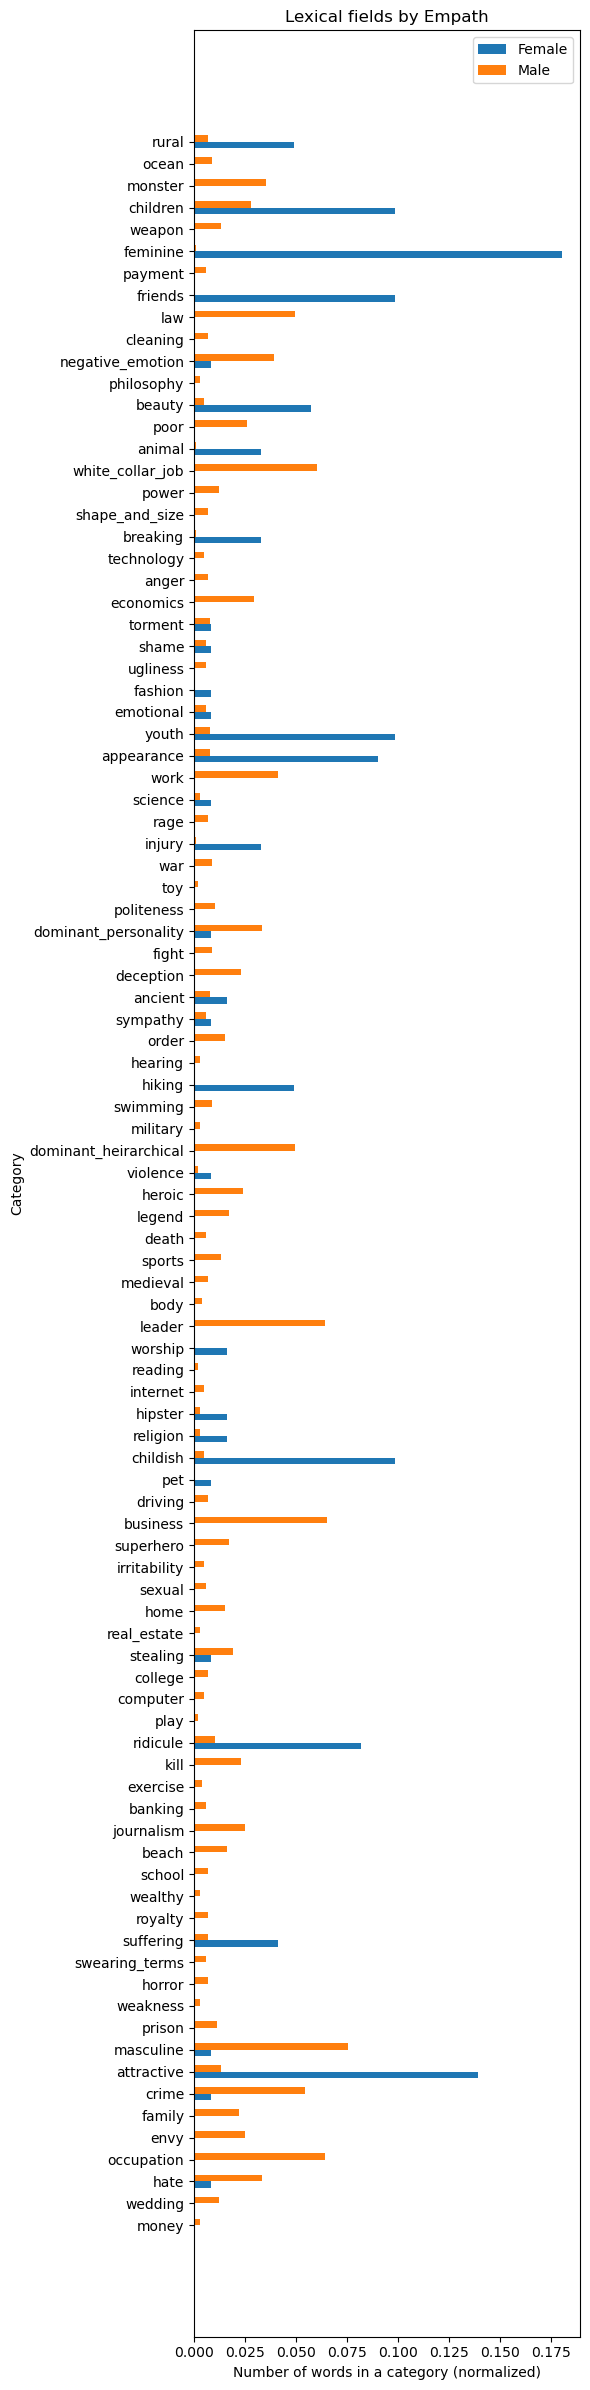

In [37]:
x = np.arange(df_category.shape[0])  # the label locations
new_x = [5*i for i in x]
new_x = np.asanyarray(new_x)
width = 1.5  # the width of the bars

fig, ax = plt.subplots(figsize=(6,24))
rects1 = ax.barh(new_x - width/2, df_category['Female'], width, align='center', label='Female')
rects2 = ax.barh(new_x + width/2, df_category['Male'], width, align='center', label='Male')
ax.set_ylabel('Category')
ax.set_xlabel('Number of words in a category (normalized)')
ax.set_title('Lexical fields by Empath')
ax.set_yticks(new_x, df_category.index)
ax.legend()
fig.tight_layout()

In [38]:
df_category.corr()

,Female,Male
Female,1.000000,-0.157649
Male,-0.157649,1.000000


Pearsons correlation coefficient of lexic fields of female and male character words is -0.158

## Question 2.2 & 2.3
For the second and third subquestion of this second part, we will repeat the procedure applied for Q2.1, but this time we will make use of the newly created dataframe 7, where we extracted all the words associated with a character in a movie. In addition for Q2.3, the words for every gender is divided into three to four time periods depending on the release of the movie. This allows us to observe the change in lexical fields over time for both female and male characters. In this part, we will go a step further and make a principle compnent analysis (PCA) with the classes created by Empath. By visualizing our different groups (male/female + different periods) we expect to find a separation between the words of male and female characters. Furthermore, our expectation is to see more variation of the lexical field of female characters between different periods than for male characters.

In [39]:
# load first part of the summary dataframe
summary_part1 = pd.read_pickle("all_summary_part1.pkl")
summary_part1 = summary_part1.reset_index(drop=True)
# drop rows with undefined Gender
summary_part1_clean = summary_part1[(~summary_part1.Gender.astype(str).str.contains('None'))
                                    & (~summary_part1['Gender'].isnull())].reset_index(drop=True)
# define column 'Gender' as type string
summary_part1_clean['Gender'] = summary_part1_clean['Gender'].astype(str)
# remove square brackets in 'Gender' column
summary_part1_clean['Gender'] = summary_part1_clean['Gender'].map(lambda x: x.lstrip('[[').rstrip(']]'))

In [89]:
# repeat same procedure for part 2
summary_part2 = pd.read_pickle("all_summary_part2.pkl")
summary_part2 = summary_part2.reset_index(drop=True)
# drop rows with undefined Gender
summary_part2_clean = summary_part2[(~summary_part2.Gender.astype(str).str.contains('None'))
                                    & (~summary_part2['Gender'].isnull())].reset_index(drop=True)
# define column 'Gender' as type string
summary_part2_clean['Gender'] = summary_part2_clean['Gender'].astype(str)
# remove square brackets in 'Gender' column
summary_part2_clean['Gender'] = summary_part2_clean['Gender'].map(lambda x: x.lstrip('[[').rstrip(']]'))

In [91]:
# repeat same procedure for part 3
summary_part3 = pd.read_pickle("all_summary_part3.pkl")
summary_part3 = summary_part3.reset_index(drop=True)
# drop rows with undefined Gender
summary_part3_clean = summary_part3[(~summary_part3.Gender.astype(str).str.contains('None'))
                                    & (~summary_part3['Gender'].isnull())].reset_index(drop=True)
# define column 'Gender' as type string
summary_part3_clean['Gender'] = summary_part3_clean['Gender'].astype(str)
# remove square brackets in 'Gender' column
summary_part3_clean['Gender'] = summary_part3_clean['Gender'].map(lambda x: x.lstrip('[[').rstrip(']]'))

In [94]:
# Merge all three parts into one dataframe
summary_all_clean = summary_part1_clean.append(summary_part2_clean, ignore_index=True).\
                        append(summary_part3_clean, ignore_index=True)
summary_all_clean.sample(3)

,film_id,Characters,Lemma,JJ,NN,NNP,NNS,PRP,PRP$,VB,VBG,VBP,VBZ,governor_words,dependent_words,Gender
38773,3028191,"[Nancy , Rod , Tina]","[Nancy, leave, the, school, early, and, ...","[own, ]","[school, jail, night, figure, glove, shock]","[Nancy, Rod, Tina, Nancy, Rod, Tina]","[nightmares, ]","[he, him, he, ]","[his, her]","[talk, kill]","[wearing, ]","[, ]","[leaves, goes, describes, realizes, leaves]",NaN,NaN,"'F'], ['M'], ['F'"
45499,3644779,[Erland Jansson],"[Gertrud, meet, she, lover, , , the, pro...","[promising, young]","[lover, pianist, park]","[Gertrud, Erland, Jansson]",[],[],[her],[],[],[],[meets],NaN,NaN,'M'
19770,2006189,[Stanton],"[one, night, in, Texas, , , Stanton, acc...","[wrong, old, welcome, golden, , enrapture...","[night, bottle, man, wood, alcohol, moons...","[Texas, Stanton, Pete, Stanton, , Great, ...","[, , , audiences, nightclubs, ambitions, ...","[, him, He, He, he, he, he, himself]","[, , his, , , , ]","[, , , , , get, suffer, get, work]","[drinking, , , performing, , playing, ea...","[, , leave, , , , ]","[gives, dies, realizes, is, , becomes, h...","[Carlisle, learns, night, teach, prefers, ...","[Texas, however, He, becomes, The, Great,...",'M'


In [95]:
# create separate dfs by gender
# for the df for men: only keep those rows that contain at least one M, and no F
# Sometimes there are several characters in one line. For this analysis we only want to keep
# the row if all the characters are men, so that we don't include words attributes to a woman
summary_all_clean_M = summary_all_clean[(summary_all_clean.Gender.str.contains('M')) &
                                           (~summary_all_clean.Gender.str.contains('F'))] 
# Vice verso for the women df
summary_all_clean_F = summary_all_clean[(summary_all_clean.Gender.str.contains('F')) &
                                           (~summary_all_clean.Gender.str.contains('M'))]

print(f'Number of female characters in summary_all: {summary_all_clean_F.shape[0]}')
print(f'Number of male characters in summary_all: {summary_all_clean_M.shape[0]}')

Number of female characters in summary_all: 18453
Number of male characters in summary_all: 34105


In [96]:
summary_all_clean_M.sample(3)

,film_id,Characters,Lemma,JJ,NN,NNP,NNS,PRP,PRP$,VB,VBG,VBP,VBZ,governor_words,dependent_words,Gender
66646,9667639,[Vikram],"[do, Vikram, accept, defeat, or, manage, ...",[],"[defeat, round]",[Vikram],[],[],[her],"[accept, manage, bring]",[],[],[Does],"[accept, manage]",NaN,'M'
8671,13950959,[George Noyce],"[with, neither, the, staff, or, patient, ...",[],"[staff, patient]","[Daniels, Ward, C, George, Noyce]",[patients],[],[],[break],[helping],[],"[decides, meets]",NaN,NaN,'M'
30355,2521806,[Meeker],"[in, the, ensue, panic, , , the, town, ...","[prophesied, tent-meeting]","[panic, town, scene, end, world, flamethr...","[Reverend, Meeker, Blob, Meeker]","[, injuries]","[him, ]","[, his]","[be, ablaze, ]","[ensuing, preaching, sounding]","[, burn]","[proclaims, sets, cuts, is]","[proclaims, crazed]","[town, Reverend, disfigured]",'M'


Analyze adjectives:

In [97]:
# in order to represent the words in a wordcloud, we need to consider each word of a gender df
# separately, and then join all words in one string (separated by a blank space)
# First, we join all words of a selected column (JJ = adjective in this case), separating them 
# by a blank space. Then, we remove all unwanted signs like []. All white space and commas are
# replaced by _, so that we can afterwards split at every _ and thus get every single word separately.
JJ_F_all = ' '.join(summary_all_clean_F['JJ'].astype(str))
JJ_F_all = JJ_F_all.replace("'","")
JJ_F_all = JJ_F_all.replace("[","")
JJ_F_all = JJ_F_all.replace("]","")
JJ_F_all = JJ_F_all.replace(" ","_")
JJ_F_all = JJ_F_all.replace(",","_")

JJ_F_all = JJ_F_all.split('_')
JJ_F_all = list(filter(None, JJ_F_all))
JJ_F_all = list(map(lambda x: x.lower(), JJ_F_all)) # convert all adj to lower case words
print(f'Number of adjectives describing female characters: {len(JJ_F_all)}')
JJ_F_all_str = ' '.join(JJ_F_all)

JJ_M_all = '_'.join(summary_all_clean_M['JJ'].astype(str))
JJ_M_all = JJ_M_all.replace("'","")
JJ_M_all = JJ_M_all.replace("[","")
JJ_M_all = JJ_M_all.replace("]","")
JJ_M_all = JJ_M_all.replace(" ","_")
JJ_M_all = JJ_M_all.replace(",","_")

JJ_M_all = JJ_M_all.split('_')
JJ_M_all = list(filter(None, JJ_M_all))
JJ_M_all = list(map(lambda x: x.lower(), JJ_M_all)) # convert all adj to lower case words
print(f'Number of adjectives describing male characters: {len(JJ_M_all)}')
JJ_M_all_str = ' '.join(JJ_M_all) # create one big string with words separated by blank space

Number of adjectives describing female characters: 43749
Number of adjectives describing male characters: 81277


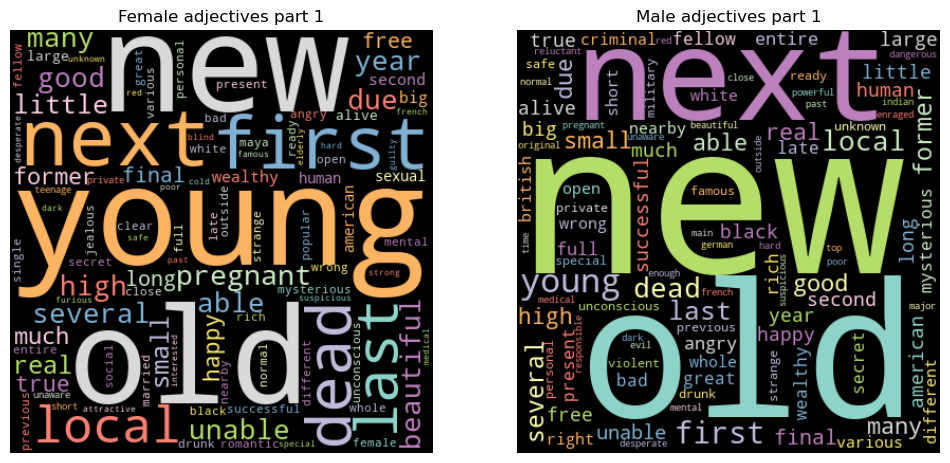

In [98]:
wordcloud_JJ_F = WordCloud(collocations=False, background_color='black', colormap='Set3',
                          max_words=100, height=400).generate(JJ_F_all_str)
wordcloud_JJ_M = WordCloud(collocations=False, background_color='black', colormap='Set3',
                          max_words=100, height=400).generate(JJ_M_all_str)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (12,6))
ax1.imshow(wordcloud_JJ_F, interpolation="bilinear")
ax1.set_title('Female adjectives')
ax1.axis("off")
ax2.imshow(wordcloud_JJ_M, interpolation="bilinear")
ax2.set_title('Male adjectives');
ax2.axis("off");

In [99]:
# just to check workcloud
df_JJ_M_all = pd.DataFrame(JJ_M_all, columns = ['adj_M'])
#df_JJ_M_all['adj_M'] = df_JJ_M_all['adj_M'].map(lambda x: x.lower())
df_JJ_M_all = pd.DataFrame(df_JJ_M_all.groupby('adj_M')['adj_M'].count())
df_JJ_M_all['adj_M'].sort_values(ascending=False)

adj_M
other             1817
new               1414
own               1324
next              1292
young             1247
                  ... 
mysophobic           1
myeloid              1
closed-circuit       1
muthaiyan            1
love-struck          1
Name: adj_M, Length: 7998, dtype: int64

Other is probably a stopword removed when generating the wordcloud due to their default built-in stopword list. That is why new appears as the most used word in the wordcloud above.

In [100]:
lexicon = Empath()
df_category = []
df_category.append(lexicon.analyze(JJ_F_all, normalize=True))
df_category.append(lexicon.analyze(JJ_M_all, normalize=True))

# transform into a dataframe
df_category = pd.DataFrame(df_category, index = ['Female','Male'])

# delete lexical field with 0 for both F and M
df_category = df_category.loc[:, (df_category != 0).any(axis=0)]

df_category = df_category.copy().T

df_category

,Female,Male
help,0.004160,0.004392
office,0.000229,0.000554
dance,0.002834,0.002042
money,0.002743,0.002842
wedding,0.009760,0.006841
...,...,...
contentment,0.000960,0.000677
writing,0.000297,0.000295
rural,0.002629,0.003064
positive_emotion,0.013280,0.013436


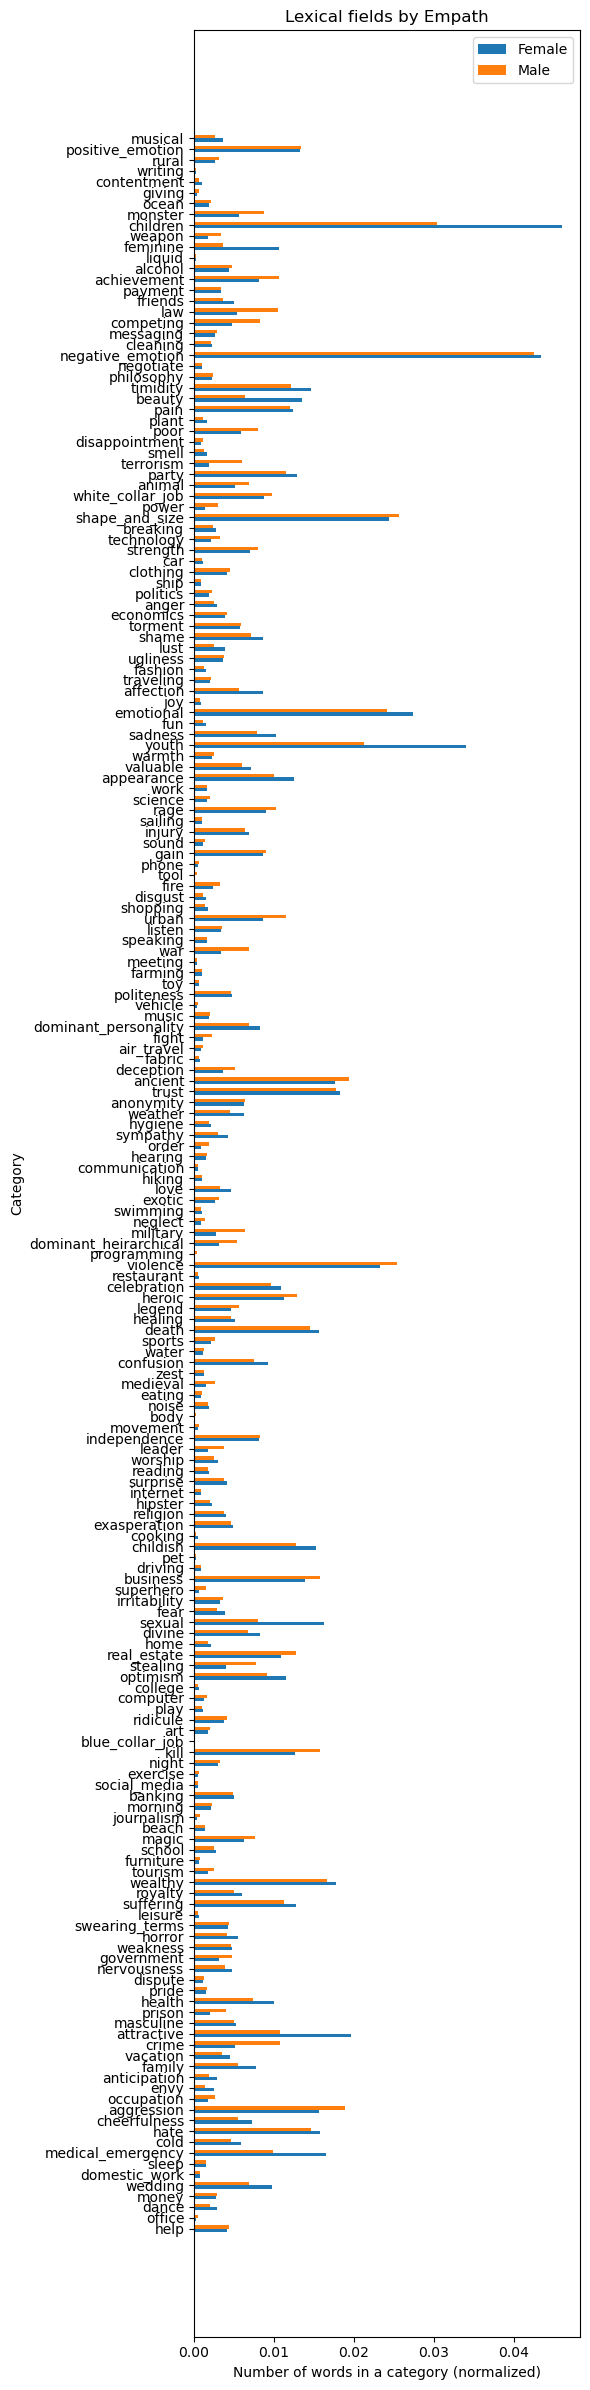

In [103]:
x = np.arange(df_category.shape[0])  # the label locations
new_x = [10*i for i in x]
new_x = np.asanyarray(new_x)
width = 3  # the width of the bars

fig, ax = plt.subplots(figsize=(6,24))
rects1 = ax.barh(new_x - width/2, df_category['Female'], width, align='center', label='Female')
rects2 = ax.barh(new_x + width/2, df_category['Male'], width, align='center', label='Male')
ax.set_ylabel('Category')
ax.set_xlabel('Number of words in a category (normalized)')
ax.set_title('Lexical fields by Empath')
ax.set_yticks(new_x, df_category.index)
ax.legend()
fig.tight_layout()

Repeat the same procedure with nouns

In [106]:
# in order to represent the words in a wordcloud, we need to consider each word of a gender df
# separately, and then join all words in one string (separated by a blank space)
# First, we join all words of a selected column (NN = adjective in this case), separating them 
# by a blank space. Then, we remove all unwanted signs like []. All white space and commas are
# replaced by _, so that we can afterwards split at every _ and thus get every single word separately.
NN_F_all = ' '.join(summary_all_clean_F['NN'].astype(str))
NN_F_all = NN_F_all.replace("'","")
NN_F_all = NN_F_all.replace("[","")
NN_F_all = NN_F_all.replace("]","")
NN_F_all = NN_F_all.replace(" ","_")
NN_F_all = NN_F_all.replace(",","_")

NN_F_all = NN_F_all.split('_')
NN_F_all = list(filter(None, NN_F_all))
NN_F_all = list(map(lambda x: x.lower(), NN_F_all)) # convert all adj to lower case words
print(f'Number of nouns describing female characters: {len(NN_F_all)}')
NN_F_all_str = ' '.join(NN_F_all)

NN_M_all = '_'.join(summary_all_clean_M['NN'].astype(str))
NN_M_all = NN_M_all.replace("'","")
NN_M_all = NN_M_all.replace("[","")
NN_M_all = NN_M_all.replace("]","")
NN_M_all = NN_M_all.replace(" ","_")
NN_M_all = NN_M_all.replace(",","_")

NN_M_all = NN_M_all.split('_')
NN_M_all = list(filter(None, NN_M_all))
NN_M_all = list(map(lambda x: x.lower(), NN_M_all)) # convert all adj to lower case words
print(f'Number of nouns describing male characters: {len(NN_M_all)}')
NN_M_all_str = ' '.join(NN_M_all) # create one big string with words separated by blank space

Number of nouns describing female characters: 132331
Number of nouns describing male characters: 250531


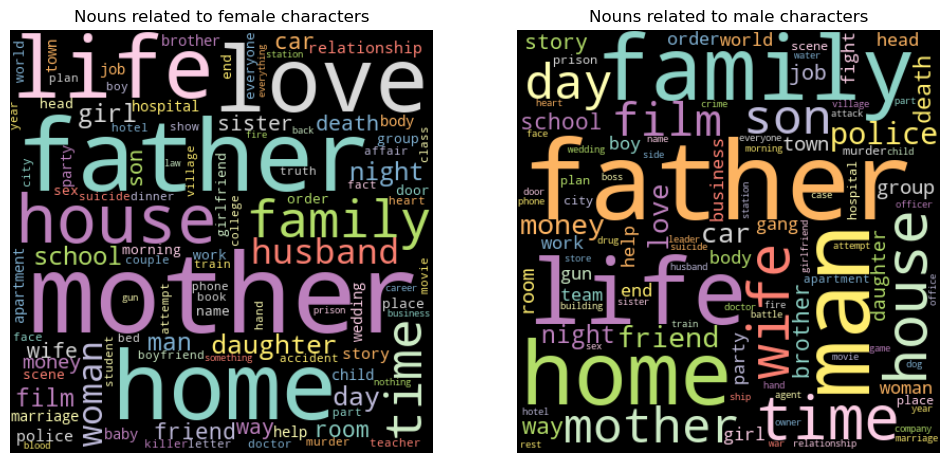

In [108]:
wordcloud_NN_F = WordCloud(collocations=False, background_color='black', colormap='Set3',
                          max_words=100, height=400).generate(NN_F_all_str)
wordcloud_NN_M = WordCloud(collocations=False, background_color='black', colormap='Set3',
                          max_words=100, height=400).generate(NN_M_all_str)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (12,6))
ax1.imshow(wordcloud_NN_F, interpolation="bilinear")
ax1.set_title('Nouns related to female characters')
ax1.axis("off")
ax2.imshow(wordcloud_NN_M, interpolation="bilinear")
ax2.set_title('Nouns related to male characters');
ax2.axis("off");

In [109]:
lexicon = Empath()
df_category = []
df_category.append(lexicon.analyze(NN_F_all, normalize=True))
df_category.append(lexicon.analyze(NN_M_all, normalize=True))

# transform into a dataframe
df_category = pd.DataFrame(df_category, index = ['Female','Male'])

# delete lexical field with 0 for both F and M
df_category = df_category.loc[:, (df_category != 0).any(axis=0)]

df_category = df_category.copy().T

df_category

,Female,Male
help,0.016005,0.015232
office,0.017910,0.018094
dance,0.012318,0.009815
money,0.011728,0.015990
wedding,0.055951,0.043819
...,...,...
contentment,0.003098,0.001988
writing,0.009975,0.007911
rural,0.006363,0.006754
positive_emotion,0.034988,0.027817


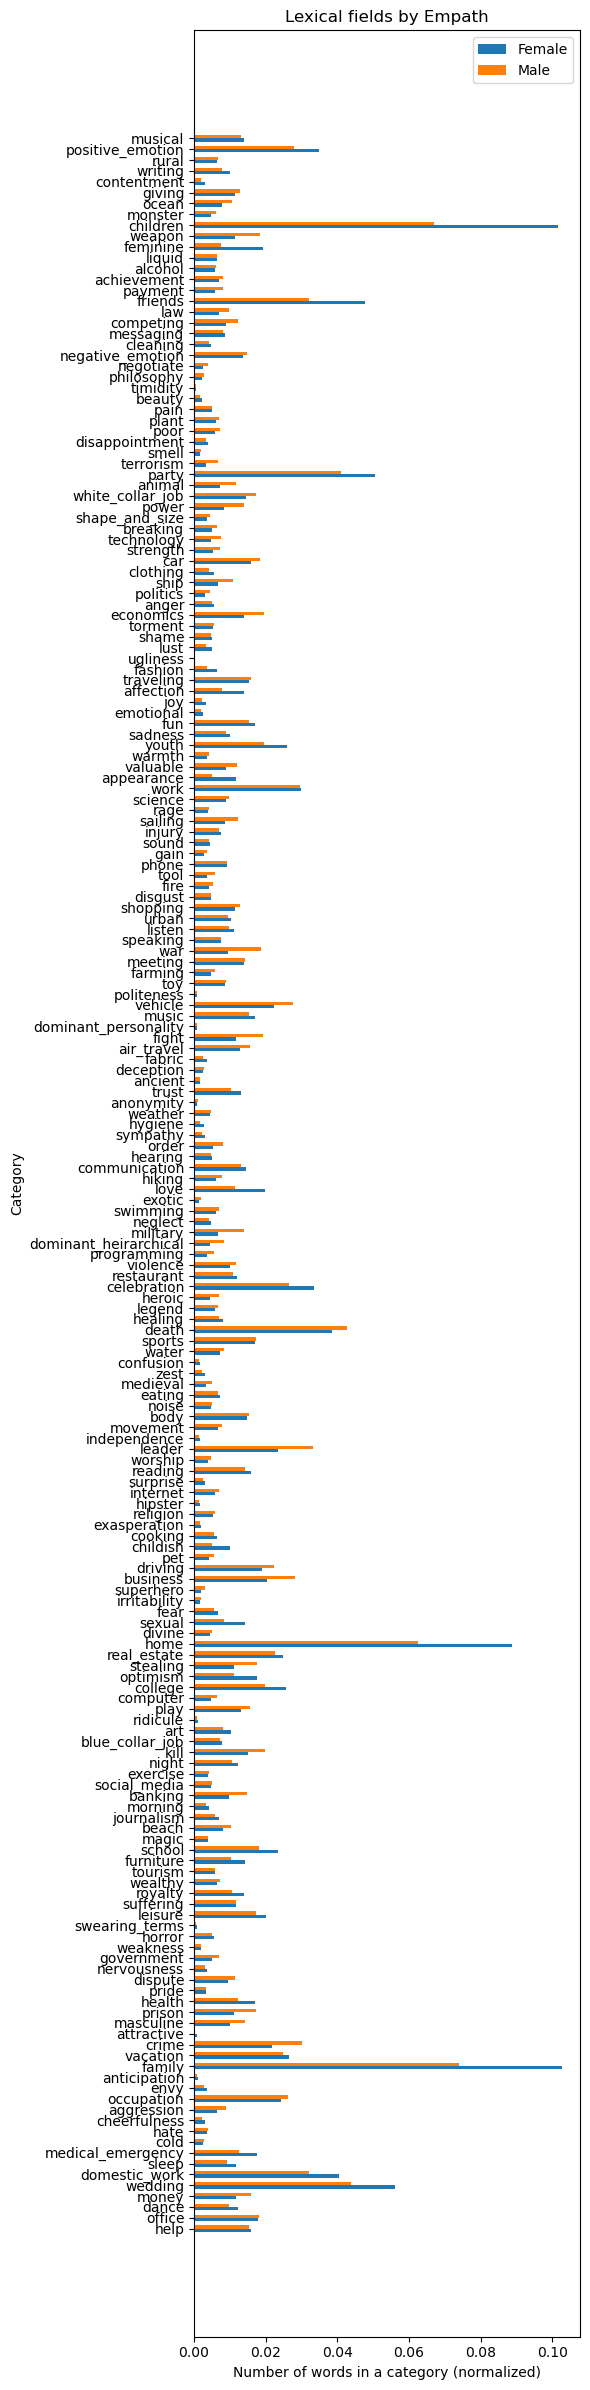

In [110]:
x = np.arange(df_category.shape[0])  # the label locations
new_x = [10*i for i in x]
new_x = np.asanyarray(new_x)
width = 3  # the width of the bars

fig, ax = plt.subplots(figsize=(6,24))
rects1 = ax.barh(new_x - width/2, df_category['Female'], width, align='center', label='Female')
rects2 = ax.barh(new_x + width/2, df_category['Male'], width, align='center', label='Male')
ax.set_ylabel('Category')
ax.set_xlabel('Number of words in a category (normalized)')
ax.set_title('Lexical fields by Empath')
ax.set_yticks(new_x, df_category.index)
ax.legend()
fig.tight_layout()

In [114]:
# only keep the once with a significant difference between men and women
df_cat_difference = df_category[abs(df_category['Female']-df_category['Male']) > 0.008]

In [115]:
df_cat_difference

,Female,Male
wedding,0.055951,0.043819
domestic_work,0.040557,0.032120
family,0.102553,0.074003
crime,0.021643,0.030180
home,0.088800,0.062611
leader,0.023471,0.033150
love,0.019663,0.011296
war,0.009416,0.018648
party,0.050540,0.040873
friends,0.047578,0.032176


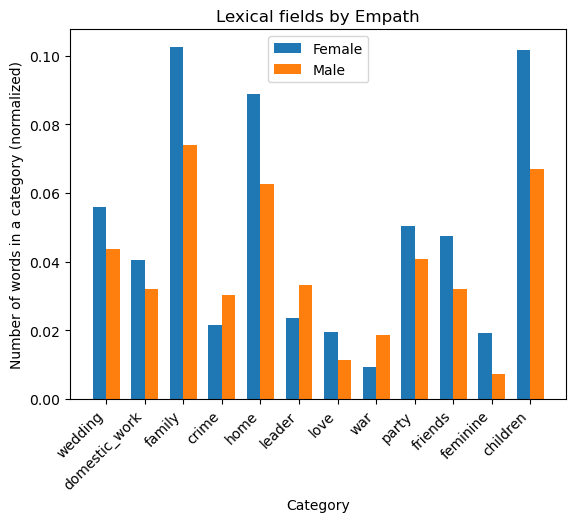

In [122]:
index = np.arange(df_cat_difference.shape[0])
bar_width = 0.35

fig, ax = plt.subplots()
female = ax.bar(index, df_cat_difference['Female'], bar_width,
                label="Female")

male = ax.bar(index+bar_width, df_cat_difference['Male'],
                 bar_width, label="Male")

ax.set_xlabel('Category')
ax.set_ylabel('Number of words in a category (normalized)')
ax.set_title('Lexical fields by Empath')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_cat_difference.index, rotation=45, ha='right')
ax.legend()

plt.show()

# Part 1 - Deeper analysis 

## Question 1.1

In [74]:
#Get the number of movies for each year
movie_yearly_count = grouped_gender_movie.groupby(by = 'Movie_year')['Wikipedia_movie_ID'].count()
grouped_gender_year = grouped_gender_year.assign(Movie_count=movie_yearly_count.tolist())
grouped_gender_year

,Movie_year,Female,Male,Female_share,Movie_count
0,1888.0,2.0,2,0.500000,1
1,1891.0,0.0,1,0.000000,1
2,1893.0,0.0,2,0.000000,1
3,1894.0,1.0,3,0.250000,4
4,1895.0,0.0,1,0.000000,1
...,...,...,...,...,...
121,2012.0,2545.0,4502,0.361147,954
122,2013.0,281.0,643,0.304113,132
123,2014.0,15.0,21,0.416667,10
124,2015.0,2.0,12,0.142857,3


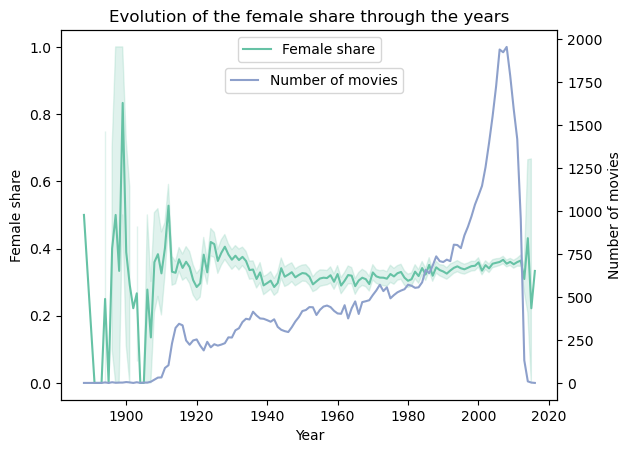

In [75]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.lineplot(data = grouped_gender_movie, x="Movie_year", 
             y="Female_share", ax = ax1, color = '#66c2a5')
ax1.set_ylabel('Female share')
ax2 = ax1.twinx()
sns.lineplot(data = grouped_gender_year, x = 'Movie_year', 
             y = 'Movie_count', color= '#8da0cb', ax = ax2)
ax2.set_ylabel('Number of movies')
ax2.grid(False)
ax1.set(xlabel='Year', ylabel='Female share')
ax2.set(ylabel='Number of movies')
plt.title('Evolution of the female share through the years')
ax1.legend(['Female share'], loc = 'upper center')
ax2.legend(['Number of movies'], loc = [0.33,0.83])

plt.show()


The share of women in movies clearly hasn't evolved significantly. Up until 1920, there are not enough movies to draw any valuable information. The same can be said from 2014. Globally, there as been no significant change throughout the years. Is that result the same for all large movie producing countries?

## Question 1.2

### Look at the largest movie producing countries

In [76]:
#Get all movies with their female share and producing country. Note thate the length of 'grouped_gender_movie_countries'
#is slightly longer than 'grouped_gender_movie' due to unique movies having more than one producing country
grouped_gender_movie_countries = pd.merge(left = grouped_gender_movie, right = movie_countries, 
                                          on = 'Wikipedia_movie_ID', how = 'left')
grouped_gender_movie_countries

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_countries
0,1082508,1888.0,2.0,2.0,0.5,United Kingdom
1,7669437,1894.0,1.0,0.0,1.0,United States of America
2,807258,1896.0,3.0,0.0,1.0,France
3,4062042,1896.0,1.0,1.0,0.5,France
4,436308,1896.0,1.0,1.0,0.5,United States of America
...,...,...,...,...,...,...
71060,32573209,2014.0,0.0,1.0,0.0,NaN
71061,35272184,2014.0,0.0,1.0,0.0,United States of America
71062,35042288,2014.0,0.0,1.0,0.0,India
71063,2312141,2015.0,0.0,4.0,0.0,United States of America


In [77]:
#for country in top_4:
#    
#    df = grouped_gender_movie_countries[grouped_gender_movie_countries.Movie_countries == country]
#
#    #Get the number of movies for each year for specific country
#    temp_movie_yearly_count = df.groupby(by = 'Movie_year')[['Wikipedia_movie_ID']].count()
#
#    #Plot the evolution of female share
#    fig = plt.figure()
#    ax1 = fig.add_subplot(111)
#    sns.lineplot(data = df, x="Movie_year", 
#                 y="Female_share", ax = ax1, color = 'r')
#    ax1.set_ylabel('Female share')
#    ax2 = ax1.twinx()
#    sns.lineplot(data = temp_movie_yearly_count, x = temp_movie_yearly_count.index, 
#                 y = 'Wikipedia_movie_ID', color= '#2ca25f', ax = ax2)
#    ax2.set_ylabel('Number of movies')
#    ax2.grid(False)
#    ax1.set(xlabel='Year', ylabel='Female share')
#    ax2.set(ylabel='Number of movies')
#    plt.title(f'{country}')
#    #ax1.legend(['Female share'], loc = 'upper center')
#    #ax2.legend(['Number of movies'], loc = [0.33,0.83])
#
#    plt.show()

We have looked at the largest producing countries. What about the evolution of the female share for countries that have the highest/lowest (on average) share?

In [78]:
#Get the total number of movies per country
movies_per_country = grouped_gender_movie_countries.groupby(by = 'Movie_countries')[['Wikipedia_movie_ID']].count()
movies_per_country.rename(columns = {'Wikipedia_movie_ID':'Tot_movie_count'},inplace = True)

grouped_gender_movie_countries = pd.merge(grouped_gender_movie_countries, movies_per_country, left_on = 'Movie_countries',
                right_index = True, how = 'left')
grouped_gender_movie_countries.head(5)

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_countries,Tot_movie_count
0,1082508,1888.0,2.0,2.0,0.5,United Kingdom,5953.0
1,7669437,1894.0,1.0,0.0,1.0,United States of America,29115.0
2,807258,1896.0,3.0,0.0,1.0,France,3473.0
3,4062042,1896.0,1.0,1.0,0.5,France,3473.0
4,436308,1896.0,1.0,1.0,0.5,United States of America,29115.0


**PROBABLY DELETE THIS** In order for the analysis to be meaningful, we consider countries that produced, on average, at least a movie a year (for the time range we have in the original dataset)

In [79]:
##Minimum number of movies that has been made by the country (to be part of next analysis)
#min_number_of_movies_produced = len(grouped_gender_movie_countries.Movie_year.unique())*5
#
##Get average female share + total movies produces by country
#FS_countries = grouped_gender_movie_countries.groupby(by = 'Movie_countries').agg({'Female_share': 'mean', 
#                                                     'Tot_movie_count': pd.Series.mode,})
#
#FS_countries = FS_countries.sort_values('Female_share')
#FS_countries = FS_countries[FS_countries.Tot_movie_count >=min_number_of_movies_produced]
#
##Retrive countries with highest/lowest average female share (that produced at least one movie a year)
#min_FS_country = FS_countries.loc[FS_countries.Female_share == np.min(FS_countries.Female_share)].index[0]
#max_FS_country = FS_countries.loc[FS_countries.Female_share == np.max(FS_countries.Female_share)].index[0]
#

In [80]:
def retrieve_info_from_statsmodels_summary(results_summary):
    '''
    Retrieves R_squared, coefficients and their associated p-values 
    from summary table of linear regression
    
    '''
    
    #Get first (contains r-squared) summary table. 
    #Convert it to html and then pandas dataframe
    results_summary_table0 = results_summary.tables[0].as_html()
    results_summary_table0 = pd.read_html(results_summary_table0)[0]
    r_squared = results_summary_table0.loc[0,3]
    
    #Get second (contains coefficients and associated p-values) summary table. 
    #Convert it to html and then pandas dataframe
    results_summary_table1 = results_summary.tables[1].as_html()
    results_summary_table1 = pd.read_html(results_summary_table1, header=0, index_col=0)[0]
    intercept = results_summary_table1.loc['Intercept','coef']
    intercept_pvalue = results_summary_table1.iloc[0,3]
    slope = results_summary_table1.loc['Movie_year','coef']
    slope_pvalue = results_summary_table1.iloc[1,3]
    
    return [r_squared, intercept, intercept_pvalue, slope, slope_pvalue]

For the regressions analysis, for each country, only the years with at least 5 movies produced were used.

In [81]:
#!pip install lxml

TypeError: lineplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

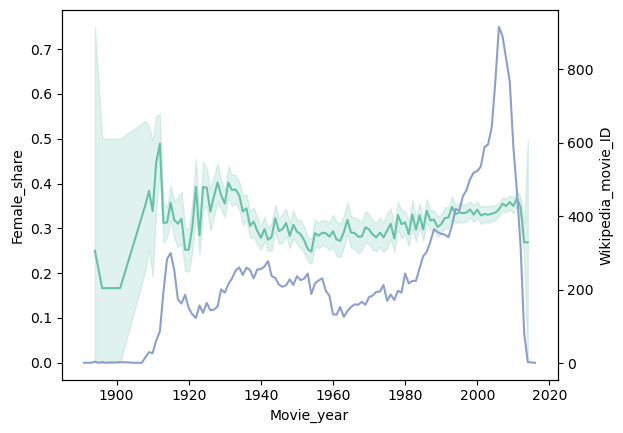

In [82]:
#extreme_FS_countries = [min_FS_country, max_FS_country]
all_countries = movie_countries.Movie_countries.unique()

#Creation of dataframe to store linear regression results
LR_df = pd.DataFrame(columns=['Country', 'R_squared', 'Intercept', 'Intercept_pvalue', 'Slope', 'Slope_pvalue'])
plot_yes = True

for country in all_countries:
    
    #Retrieve the data of the specific country
    df = grouped_gender_movie_countries[grouped_gender_movie_countries.Movie_countries == country]

    #Get the number of movies per year for specific country
    temp_movie_yearly_count = df.groupby(by = 'Movie_year')[['Wikipedia_movie_ID']].count()
    
    #Get only the years where there are at least 5 movies produced
    years_of_interest = temp_movie_yearly_count[temp_movie_yearly_count.Wikipedia_movie_ID >= 3].index

    #Get the movies that respect condition above
    df = df[df.Movie_year.isin(years_of_interest)]
    
    #df might be empty if the country doesn't meet the above criteria
    if df.empty:
        continue
        
    #Linear regression
    mod = smf.ols(formula = 'Female_share ~ Movie_year', data = df)
    res = mod.fit()
    results = res.summary()

    #Retrieve R_squared, coefficients and associated p-values into a list
    LR_list = retrieve_info_from_statsmodels_summary(results)
    LR_list.insert(0, country)
    
    #Add the linear regression parameters to LR_df
    LR_df.loc[len(LR_df)] = LR_list


    if plot_yes:
        
        #Plot the evolution of female share
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        
        #Plot Female share across the years
        sns.lineplot(data = df, x="Movie_year", 
                     y="Female_share", ax = ax1, color = '#66c2a5')
        
        ax2 = ax1.twinx()
        
        #Plot the number of movie per year
        sns.lineplot(data = temp_movie_yearly_count, x = temp_movie_yearly_count.index, 
                     y = 'Wikipedia_movie_ID', color= '#8da0cb', ax = ax2)
        
        
        #Plot linear regression line
        slope = LR_df[LR_df.Country == country]['Slope'].values
        intercept = LR_df[LR_df.Country == country]['Intercept'].values

        x_series = df.Movie_year.sort_values().unique()
        y_series = slope*x_series + intercept
        sns.lineplot(x_series, y_series, ax = ax1, color = '#fc8d62')
        
        #Make nice graph
        ax1.set_ylabel('Female share')
        ax2.set_ylabel('Number of movies')
        ax2.grid(False)
        ax1.set(xlabel='Year', ylabel='Female share')
        ax2.set(ylabel='Number of movies')
        ax1.yaxis.label.set_color('#66c2a5')
        ax2.yaxis.label.set_color('#8da0cb')
        ax1.set_xlim([min(years_of_interest)-3,max(years_of_interest)+3])
        ax1.set_ylim([0,1])
        plt.title(f'{country}')
        plt.show()

In [83]:
LR_df[(LR_df.Intercept_pvalue<0.05) & (LR_df.Slope_pvalue<0.05)].sort_values('Slope')

,Country,R_squared,Intercept,Intercept_pvalue,Slope,Slope_pvalue


In [84]:
LR_df.sort_values('R_squared', ascending = False)

,Country,R_squared,Intercept,Intercept_pvalue,Slope,Slope_pvalue
0,United States of America,0.001,-0.0593,0.51,0.0002,0.0


# **Questions:** If intercept has high p-value but slope has low p-value, can we interpret just the slope?
Yes!
    Look at India, United Kingdom, United States of America, Hong Kong

## Question 1.3 - Trends across genres

In [85]:
#Get all movies with their female share and genre. Note thate the length of 'grouped_gender_movie_genres'
#is slightly longer than 'grouped_gender_movie' due to unique movies having more than one genre
grouped_gender_movie_genres = pd.merge(left = grouped_gender_movie, right = movie_genres, 
                                          on = 'Wikipedia_movie_ID', how = 'left')
grouped_gender_movie_genres

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_genres
0,1082508,1888.0,2.0,2.0,0.5,Short Film
1,1082508,1888.0,2.0,2.0,0.5,Silent film
2,1082508,1888.0,2.0,2.0,0.5,Indie
3,1082508,1888.0,2.0,2.0,0.5,Black-and-white
4,7669437,1894.0,1.0,0.0,1.0,Short Film
...,...,...,...,...,...,...
204255,35042288,2014.0,0.0,1.0,0.0,NaN
204256,2312141,2015.0,0.0,4.0,0.0,Crime Fiction
204257,2312141,2015.0,0.0,4.0,0.0,Science Fiction
204258,2312141,2015.0,0.0,4.0,0.0,Action


In [86]:
#Get the total number of movies per genre
movies_per_genre = grouped_gender_movie_genres.groupby(by = 'Movie_genres')[['Wikipedia_movie_ID']].count()
movies_per_genre.rename(columns = {'Wikipedia_movie_ID':'Tot_movie_count'},inplace = True)

grouped_gender_movie_genres = pd.merge(grouped_gender_movie_genres, movies_per_genre, left_on = 'Movie_genres',
                right_index = True, how = 'left')
grouped_gender_movie_genres

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_genres,Tot_movie_count
0,1082508,1888.0,2.0,2.0,0.5,Short Film,4452.0
1,1082508,1888.0,2.0,2.0,0.5,Silent film,3987.0
2,1082508,1888.0,2.0,2.0,0.5,Indie,6131.0
3,1082508,1888.0,2.0,2.0,0.5,Black-and-white,7325.0
4,7669437,1894.0,1.0,0.0,1.0,Short Film,4452.0
...,...,...,...,...,...,...,...
204255,35042288,2014.0,0.0,1.0,0.0,NaN,NaN
204256,2312141,2015.0,0.0,4.0,0.0,Crime Fiction,5934.0
204257,2312141,2015.0,0.0,4.0,0.0,Science Fiction,2646.0
204258,2312141,2015.0,0.0,4.0,0.0,Action,7776.0


In [87]:
#extreme_FS_countries = [min_FS_country, max_FS_country]
all_genres = movie_genres.Movie_genres.unique()

#Creation of dataframe to store linear regression results
LR_df = pd.DataFrame(columns=['Genre', 'R_squared', 'Intercept', 'Intercept_pvalue', 'Slope', 'Slope_pvalue'])
plot_yes = False

for genre in all_genres:
    
    #Retrieve the data of the specific genre
    df = grouped_gender_movie_genres[grouped_gender_movie_genres.Movie_genres == genre]

    #Get the number of movies per year for specific genre
    temp_movie_yearly_count = df.groupby(by = 'Movie_year')[['Wikipedia_movie_ID']].count()
    
    #Get only the years where there are at least 5 movies produced
    years_of_interest = temp_movie_yearly_count[temp_movie_yearly_count.Wikipedia_movie_ID >= 3].index

    #Get the movies that respect condition above
    df = df[df.Movie_year.isin(years_of_interest)]
    
    #df might be empty if the genre doesn't meet the above criteria
    if df.empty:
        continue
        
    #Linear regression
    mod = smf.ols(formula = 'Female_share ~ Movie_year', data = df)
    res = mod.fit()
    results = res.summary()

    #Retrieve R_squared, coefficients and associated p-values into a list
    LR_list = retrieve_info_from_statsmodels_summary(results)
    LR_list.insert(0, genre)
    
    #Add the linear regression parameters to LR_df
    LR_df.loc[len(LR_df)] = LR_list


    if plot_yes:
        
        #Plot the evolution of female share
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        
        #Plot Female share across the years
        sns.lineplot(data = df, x="Movie_year", 
                     y="Female_share", ax = ax1, color = '#66c2a5')
        
        ax2 = ax1.twinx()
        
        #Plot the number of movie per year
        sns.lineplot(data = temp_movie_yearly_count, x = temp_movie_yearly_count.index, 
                     y = 'Wikipedia_movie_ID', color= '#8da0cb', ax = ax2)
        
        
        #Plot linear regression line
        slope = LR_df[LR_df.Genre == genre]['Slope'].values
        intercept = LR_df[LR_df.Genre == genre]['Intercept'].values

        x_series = df.Movie_year.sort_values().unique()
        y_series = slope*x_series + intercept
        sns.lineplot(x_series, y_series, ax = ax1, color = '#fc8d62')
        
        #Make nice graph
        ax1.set_ylabel('Female share')
        ax2.set_ylabel('Number of movies')
        ax2.grid(False)
        ax1.set(xlabel='Year', ylabel='Female share')
        ax2.set(ylabel='Number of movies')
        ax1.yaxis.label.set_color('#66c2a5')
        ax2.yaxis.label.set_color('#8da0cb')
        ax1.set_xlim([min(years_of_interest)-3,max(years_of_interest)+3])
        ax1.set_ylim([0,1])
        plt.title(f'{genre}')
        plt.show()

In [89]:
#LR_df[(LR_df.Intercept_pvalue<0.05) & (LR_df.Slope_pvalue<0.05)].sort_values('R_squared', ascending = False).head(30)
LR_df[LR_df.Slope_pvalue<0.05].sort_values('R_squared', ascending = False).head(30)

,Genre,R_squared,Intercept,Intercept_pvalue,Slope,Slope_pvalue
223,Glamorized Spy Film,0.415,-179.9542,0.044,0.0917,0.044
213,Revisionist Western,0.109,-5.9828,0.056,0.0031,0.049
209,Alien Film,0.094,-4.7558,0.038,0.0025,0.029
230,Hip hop movies,0.093,20.9826,0.024,-0.0104,0.025
72,Sci-Fi Horror,0.089,-5.4739,0.006,0.0029,0.004
69,Action Comedy,0.076,-10.6037,0.002,0.0054,0.001
171,Holiday Film,0.073,-41.2556,0.025,0.0208,0.024
15,Indie,0.054,-2.6508,0.000,0.0015,0.000
70,Blaxploitation,0.051,-48.6285,0.041,0.0248,0.040
44,Marriage Drama,0.042,-2.9865,0.074,0.0017,0.041


## Question 1.4 - Observational study

In [90]:
actors = actor[actor.Gender == 'M']
actress = actor[actor.Gender == 'F']

#Delete all rows with a nan -- DO THIS???
actors = actors.dropna()
actress = actress.dropna()

<AxesSubplot:>

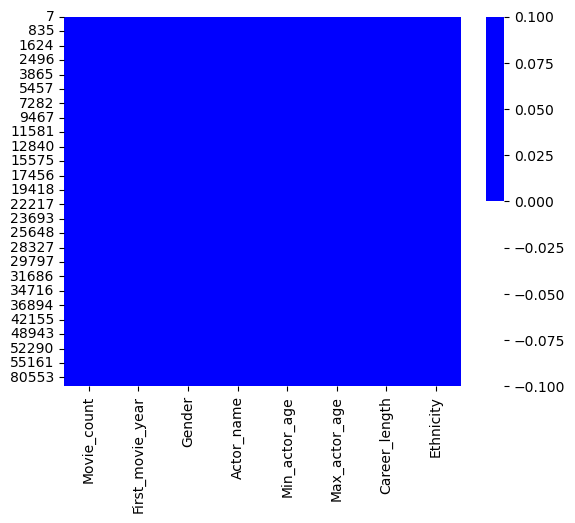

In [91]:
matching_critera = ["First_movie_year","Min_actor_age", "Max_actor_age", "Career_length", "Ethnicity"]

#Match athletes on 'matching_criteria' and delete duplicates as we do 1-to-1 matching
matching_actors = pd.merge(actors,actress,how='inner',on = matching_critera)

#1-on-1 matching
matching_actors = matching_actors[matching_actors.Actor_name_x.duplicated(keep='first') == False]
matching_actors = matching_actors[matching_actors.Actor_name_y.duplicated(keep='first') == False]

sns.heatmap(actress.isnull(), cmap=['w','b'])

In [92]:
#Rearranging columns to change shape of df
matching_actors['First_movie_year_y'] = matching_actors.loc[:, 'First_movie_year']
matching_actors['Min_actor_age_y'] = matching_actors.loc[:, 'Min_actor_age']
matching_actors['Max_actor_age_y'] = matching_actors.loc[:, 'Max_actor_age']
matching_actors['Career_length_y'] = matching_actors.loc[:, 'Career_length']
matching_actors['Ethnicity_y'] = matching_actors.loc[:, 'Ethnicity']
matching_actors=matching_actors.rename(columns={'First_movie_year':'First_movie_year_x',
                                                  'Min_actor_age':'Min_actor_age_x',
                                                  'Max_actor_age':'Max_actor_age_x',
                                                  'Career_length':'Career_length_x',
                                                  'Ethnicity':'Ethnicity_x'})

matching_actors

,Movie_count_x,First_movie_year_x,Gender_x,Actor_name_x,Min_actor_age_x,Max_actor_age_x,Career_length_x,Ethnicity_x,Movie_count_y,Gender_y,Actor_name_y,First_movie_year_y,Min_actor_age_y,Max_actor_age_y,Career_length_y,Ethnicity_y
0,17,1995.0,M,Jonny Lee Miller,22.0,39.0,18.0,English people,24,F,Saffron Burrows,1995.0,22.0,39.0,18.0,English people
1,17,1985.0,M,Tim McInnerny,28.0,54.0,27.0,English people,12,F,Lesley Manville,1985.0,28.0,54.0,27.0,English people
2,9,1997.0,M,Mark Benton,31.0,43.0,13.0,English people,11,F,Tamsin Greig,1997.0,31.0,43.0,13.0,English people
3,6,2002.0,M,Ameet Chana,26.0,35.0,10.0,British Indian people,4,F,Parminder Nagra,2002.0,26.0,35.0,10.0,British Indian people
4,1,2008.0,M,Ryan Sypek,25.0,25.0,1.0,white Americans,1,F,Valentina Vaughn,2008.0,25.0,25.0,1.0,white Americans


In [93]:
#split mathing actors into a dataset for x and one for y
matching_actors_x = matching_actors[matching_actors.columns[0:int(matching_actors.shape[1]/2)]]
matching_actors_y = matching_actors[matching_actors.columns[int(matching_actors.shape[1]/2):]]

#Sort both lexicographically to get the same column order
matching_actors_x = matching_actors_x.reindex(sorted(matching_actors_x.columns), axis=1)
matching_actors_y = matching_actors_y.reindex(sorted(matching_actors_y.columns), axis=1)

#Remove suffix:
matching_actors_x.columns = matching_actors_x.columns.str.replace("_x", "")
matching_actors_y.columns = matching_actors_y.columns.str.replace("_y", "")

In [94]:
#Concatane both datasets (vertically)
matching_one_actors_row = pd.concat([matching_actors_x,matching_actors_y], ignore_index = True)
matching_one_actors_row 

,Actor_name,Career_length,Ethnicity,First_movie_year,Gender,Max_actor_age,Min_actor_age,Movie_count,First_movieear
0,Jonny Lee Miller,18.0,English people,1995.0,M,39.0,22.0,17,NaN
1,Tim McInnerny,27.0,English people,1985.0,M,54.0,28.0,17,NaN
2,Mark Benton,13.0,English people,1997.0,M,43.0,31.0,9,NaN
3,Ameet Chana,10.0,British Indian people,2002.0,M,35.0,26.0,6,NaN
4,Ryan Sypek,1.0,white Americans,2008.0,M,25.0,25.0,1,NaN
5,Saffron Burrows,18.0,English people,NaN,F,39.0,22.0,24,1995.0
6,Lesley Manville,27.0,English people,NaN,F,54.0,28.0,12,1985.0
7,Tamsin Greig,13.0,English people,NaN,F,43.0,31.0,11,1997.0
8,Parminder Nagra,10.0,British Indian people,NaN,F,35.0,26.0,4,2002.0
9,Valentina Vaughn,1.0,white Americans,NaN,F,25.0,25.0,1,2008.0


In [95]:
#Apply log on Movie_count as they are heavy-tailed
matching_one_actors_row['log_Movie_count']=matching_one_actors_row.Movie_count.apply(lambda x: np.log(x))
matching_one_actors_row

,Actor_name,Career_length,Ethnicity,First_movie_year,Gender,Max_actor_age,Min_actor_age,Movie_count,First_movieear,log_Movie_count
0,Jonny Lee Miller,18.0,English people,1995.0,M,39.0,22.0,17,NaN,2.833213
1,Tim McInnerny,27.0,English people,1985.0,M,54.0,28.0,17,NaN,2.833213
2,Mark Benton,13.0,English people,1997.0,M,43.0,31.0,9,NaN,2.197225
3,Ameet Chana,10.0,British Indian people,2002.0,M,35.0,26.0,6,NaN,1.791759
4,Ryan Sypek,1.0,white Americans,2008.0,M,25.0,25.0,1,NaN,0.000000
5,Saffron Burrows,18.0,English people,NaN,F,39.0,22.0,24,1995.0,3.178054
6,Lesley Manville,27.0,English people,NaN,F,54.0,28.0,12,1985.0,2.484907
7,Tamsin Greig,13.0,English people,NaN,F,43.0,31.0,11,1997.0,2.397895
8,Parminder Nagra,10.0,British Indian people,NaN,F,35.0,26.0,4,2002.0,1.386294
9,Valentina Vaughn,1.0,white Americans,NaN,F,25.0,25.0,1,2008.0,0.000000


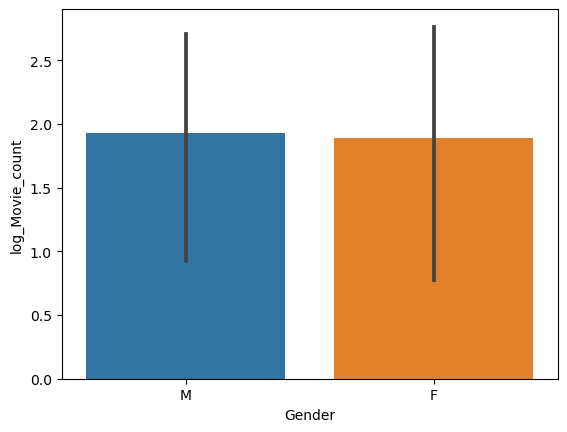

In [96]:
plt.figure()
sns.barplot(data = matching_one_actors_row, x = 'Gender', y = 'log_Movie_count')
plt.show()

## Question 1.5: What are the predictors of the share of women and men cast in a movie?

For Q1.5, identify if there are predictors for female share in a given movie, such as movie genre, box office revenue, runtime, country, etc. This will be done using a regression analysis.

# Regarder encore

In [163]:
df_regression.head()

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_genres,Movie_countries,Movie_name,Movie_boxoffice_revenue,Movie_runtime
0,1082508,1888.0,2.0,2.0,0.5,Short Film,United Kingdom,Roundhay Garden Scene,NaN,0.03
1,1082508,1888.0,2.0,2.0,0.5,Silent film,United Kingdom,Roundhay Garden Scene,NaN,0.03
2,1082508,1888.0,2.0,2.0,0.5,Indie,United Kingdom,Roundhay Garden Scene,NaN,0.03
3,1082508,1888.0,2.0,2.0,0.5,Black-and-white,United Kingdom,Roundhay Garden Scene,NaN,0.03
4,7669437,1894.0,1.0,0.0,1.0,Short Film,United States of America,Carmencita,NaN,0.50


In [174]:
#Linear regression
#mod = smf.ols(formula = 'Female_share ~ Movie_year + Movie_genres + Movie_countries + \#
  #                      Movie_boxoffice_revenue + Movie_runtime', data = df_regression)
    
mod_genres = smf.ols(formula = 'Female_share ~ Movie_genres', data = df_regression)
res_genres = mod_genres.fit()
results_genres = res_genres.summary()


In [175]:
print(results_genres)

                            OLS Regression Results                            
Dep. Variable:           Female_share   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     44.63
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:09:09   Log-Likelihood:                 23606.
No. Observations:              252511   AIC:                        -4.649e+04
Df Residuals:                  252152   BIC:                        -4.275e+04
Df Model:                         358                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [176]:
# feature names
variables_genres = res_genres.params.index

# quantifying uncertainty!

# coefficients
coefficients_genres = res_genres.params.values

# p-values
p_values_genres = res_genres.pvalues

# standard errors
standard_errors_genres = res_genres.bse.values

#confidence intervals
res_genres.conf_int()

,0,1
Intercept,0.245254,0.329618
Movie_genres[T.Acid western],-0.294611,-0.040440
Movie_genres[T.Action],-0.078027,0.006806
Movie_genres[T.Action Comedy],-0.090896,0.013021
Movie_genres[T.Action Thrillers],-0.094238,-0.003550
...,...,...
Movie_genres[T.World History],-0.258813,-0.038280
Movie_genres[T.World cinema],0.017152,0.101966
Movie_genres[T.Wuxia],-0.073283,0.035982
Movie_genres[T.Z movie],-0.397252,0.219817


In [177]:
len(res_genres.conf_int())

363

In [196]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_genres[1:], variables_genres[1:], standard_errors_genres[1:], p_values_genres[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

In [207]:
l1_genres = l1[:25]+l1[len(l1)-15:]
l2_genres = l2[:25]+l2[len(l2)-15:]
l3_genres = l3[:25]+l3[len(l3)-15:]
l4_genres = l4[:25]+l4[len(l4)-15:]

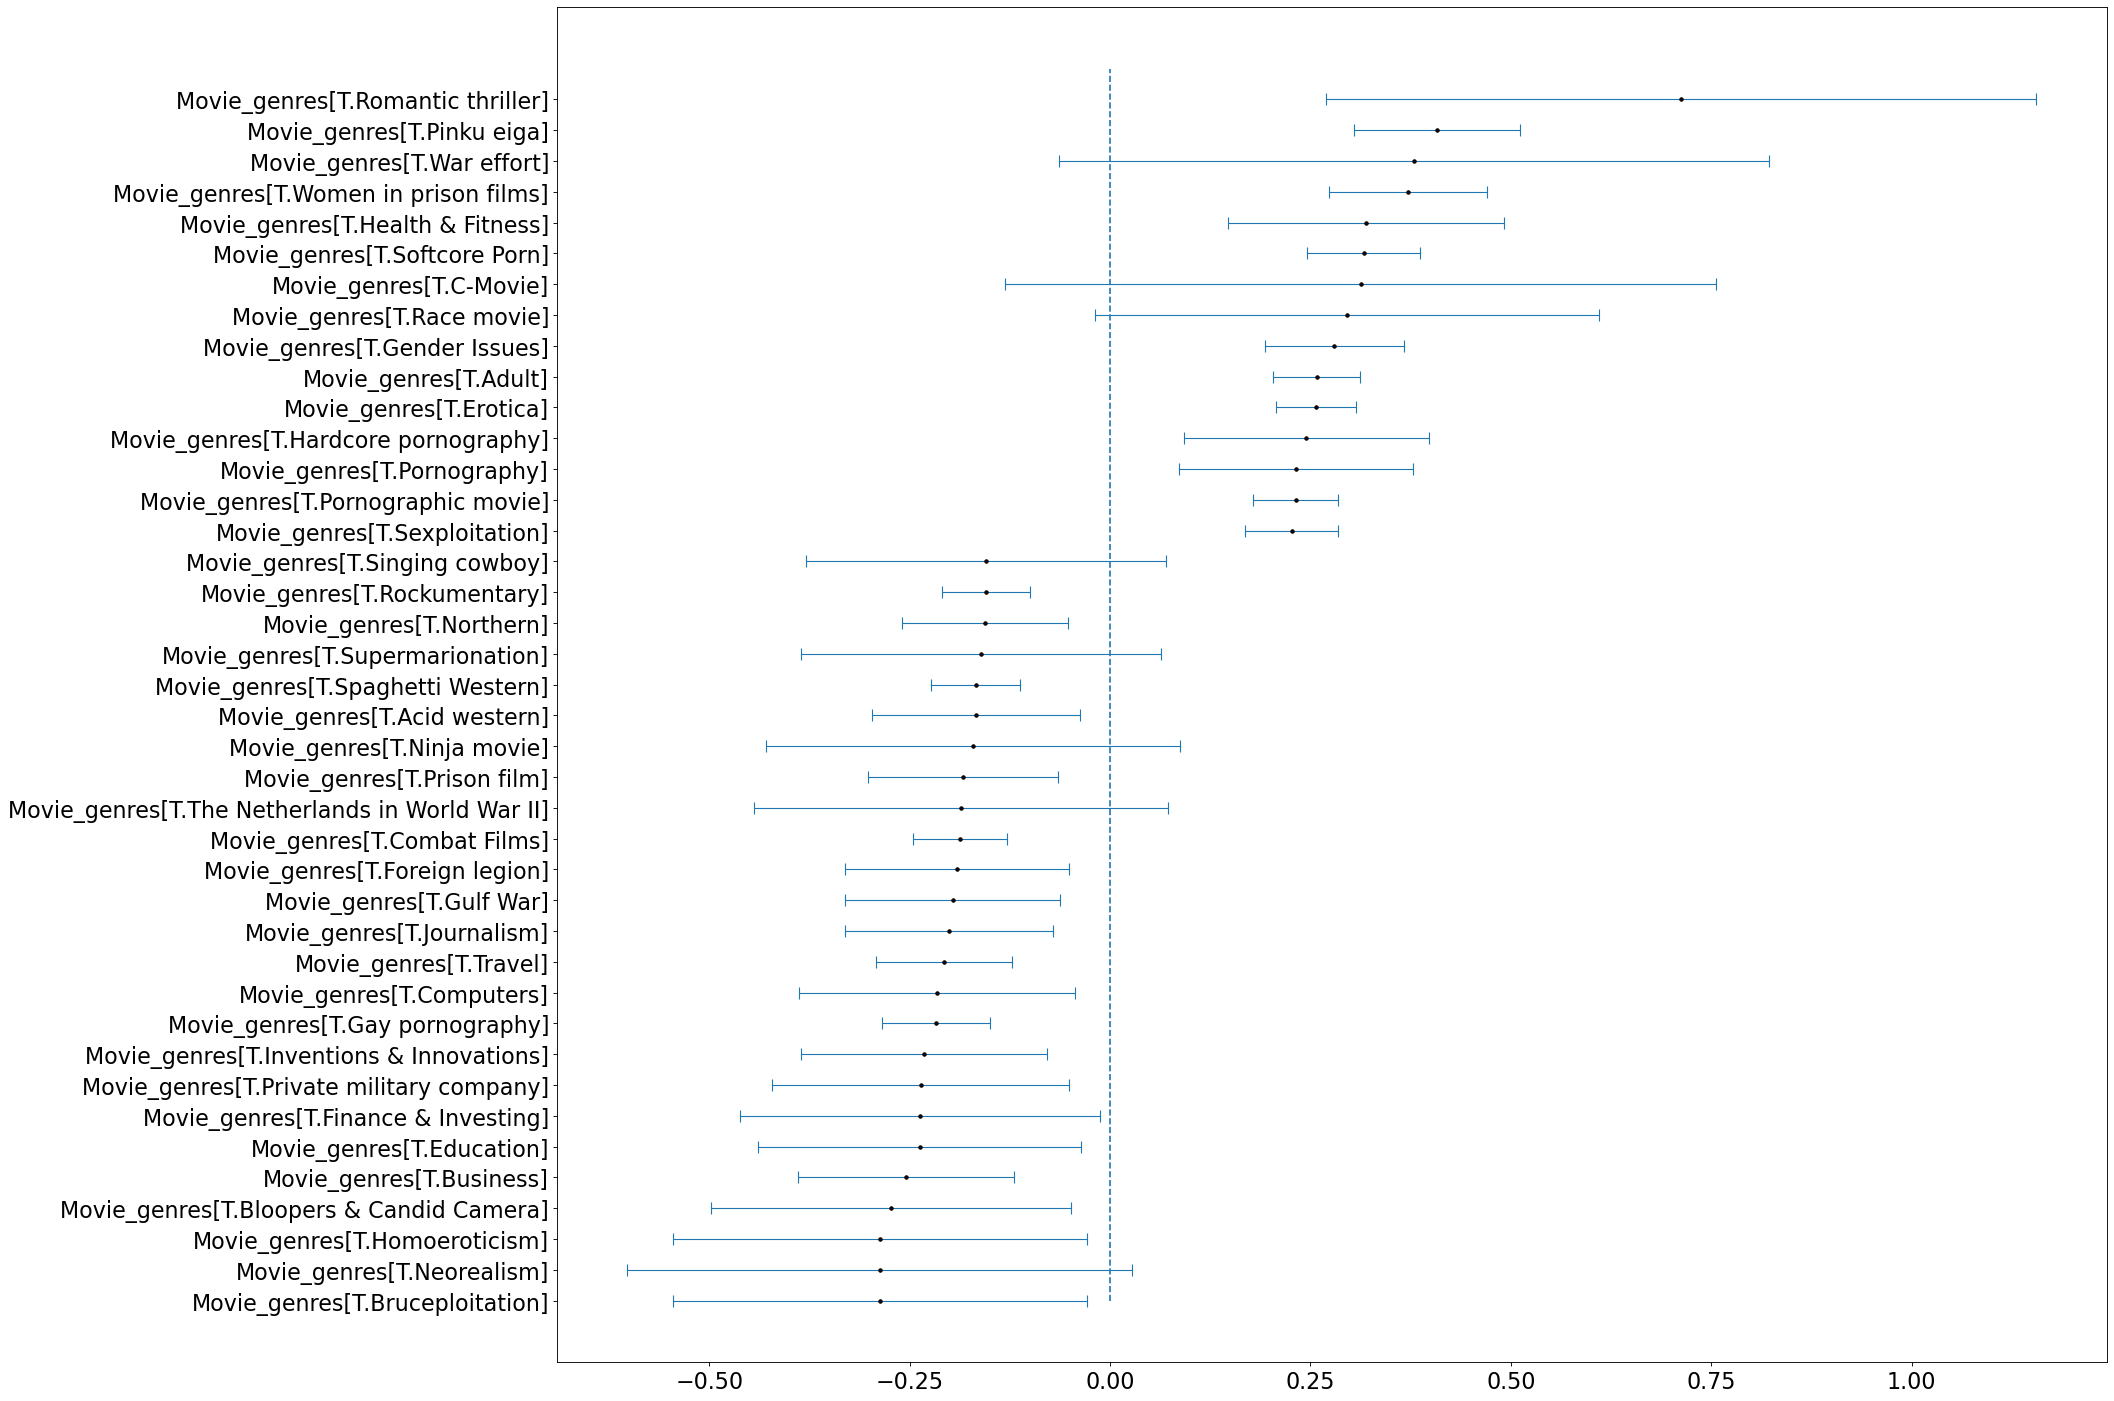

In [213]:
#fancy plotting

from matplotlib.pyplot import figure

figure(figsize=(25, 22), dpi=80)

plt.errorbar(l1_genres, np.array(range(len(l1_genres))), xerr= 2*np.array(l3_genres), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1_genres), linestyle = '--')

plt.yticks(range(len(l2_genres)),l2_genres);

BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Interpretation:
- Movie genres 'Bruceploitation' is a sigificant negative predictor of female_share.

Now for countries:

In [220]:
mod_countries = smf.ols(formula = 'Female_share ~ Movie_countries', data = df_regression)
res_countries = mod_countries.fit()
results_countries = res_countries.summary()
print(results_countries)

                            OLS Regression Results                            
Dep. Variable:           Female_share   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     27.92
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:27:15   Log-Likelihood:                 19955.
No. Observations:              247338   AIC:                        -3.963e+04
Df Residuals:                  247197   BIC:                        -3.816e+04
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [221]:
# feature names
variables_countries = res_countries.params.index

# quantifying uncertainty!

# coefficients
coefficients_countries = res_countries.params.values

# p-values
p_values_countries = res_countries.pvalues

# standard errors
standard_errors_countries = res_countries.bse.values

#confidence intervals
res_countries.conf_int()

,0,1
Intercept,0.391000,0.562649
Movie_countries[T.Albania],-0.382068,-0.161581
Movie_countries[T.Algeria],-0.339866,-0.128953
Movie_countries[T.Argentina],-0.238337,-0.064951
Movie_countries[T.Armenia],-0.160078,0.071012
...,...,...
Movie_countries[T.Weimar Republic],-0.299121,-0.119512
Movie_countries[T.West Germany],-0.236582,-0.063313
Movie_countries[T.Yugoslavia],-0.318408,-0.142227
Movie_countries[T.Zambia],-0.336640,0.036052


In [222]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_countries[1:], variables_countries[1:], standard_errors_countries[1:], p_values_countries[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

In [223]:
l1_countries = l1[:25]+l1[len(l1)-15:]
l2_countries = l2[:25]+l2[len(l2)-15:]
l3_countries = l3[:25]+l3[len(l3)-15:]
l4_countries = l4[:25]+l4[len(l4)-15:]

In [224]:
l2_countries

('Movie_countries[T.Crime]',
 'Movie_countries[T.Guinea]',
 'Movie_countries[T.Kingdom of Italy]',
 'Movie_countries[T.Haiti]',
 'Movie_countries[T.Socialist Federal Republic of Yugoslavia]',
 'Movie_countries[T.Cameroon]',
 'Movie_countries[T.Jamaica]',
 'Movie_countries[T.German Language]',
 'Movie_countries[T.Burkina Faso]',
 'Movie_countries[T.Iraq]',
 'Movie_countries[T.Bhutan]',
 'Movie_countries[T.Kenya]',
 'Movie_countries[T.Panama]',
 'Movie_countries[T.Palestinian territories]',
 'Movie_countries[T.Isle of Man]',
 'Movie_countries[T.Aruba]',
 'Movie_countries[T.Mandatory Palestine]',
 'Movie_countries[T.Albania]',
 'Movie_countries[T.Azerbaijan]',
 'Movie_countries[T.Uruguay]',
 'Movie_countries[T.Republic of Macedonia]',
 'Movie_countries[T.Korea]',
 'Movie_countries[T.Ukrainian SSR]',
 'Movie_countries[T.Libya]',
 'Movie_countries[T.Malayalam Language]',
 'Movie_countries[T.Lebanon]',
 'Movie_countries[T.Palestinian Territories]',
 'Movie_countries[T.Turkmenistan]',
 'Movie

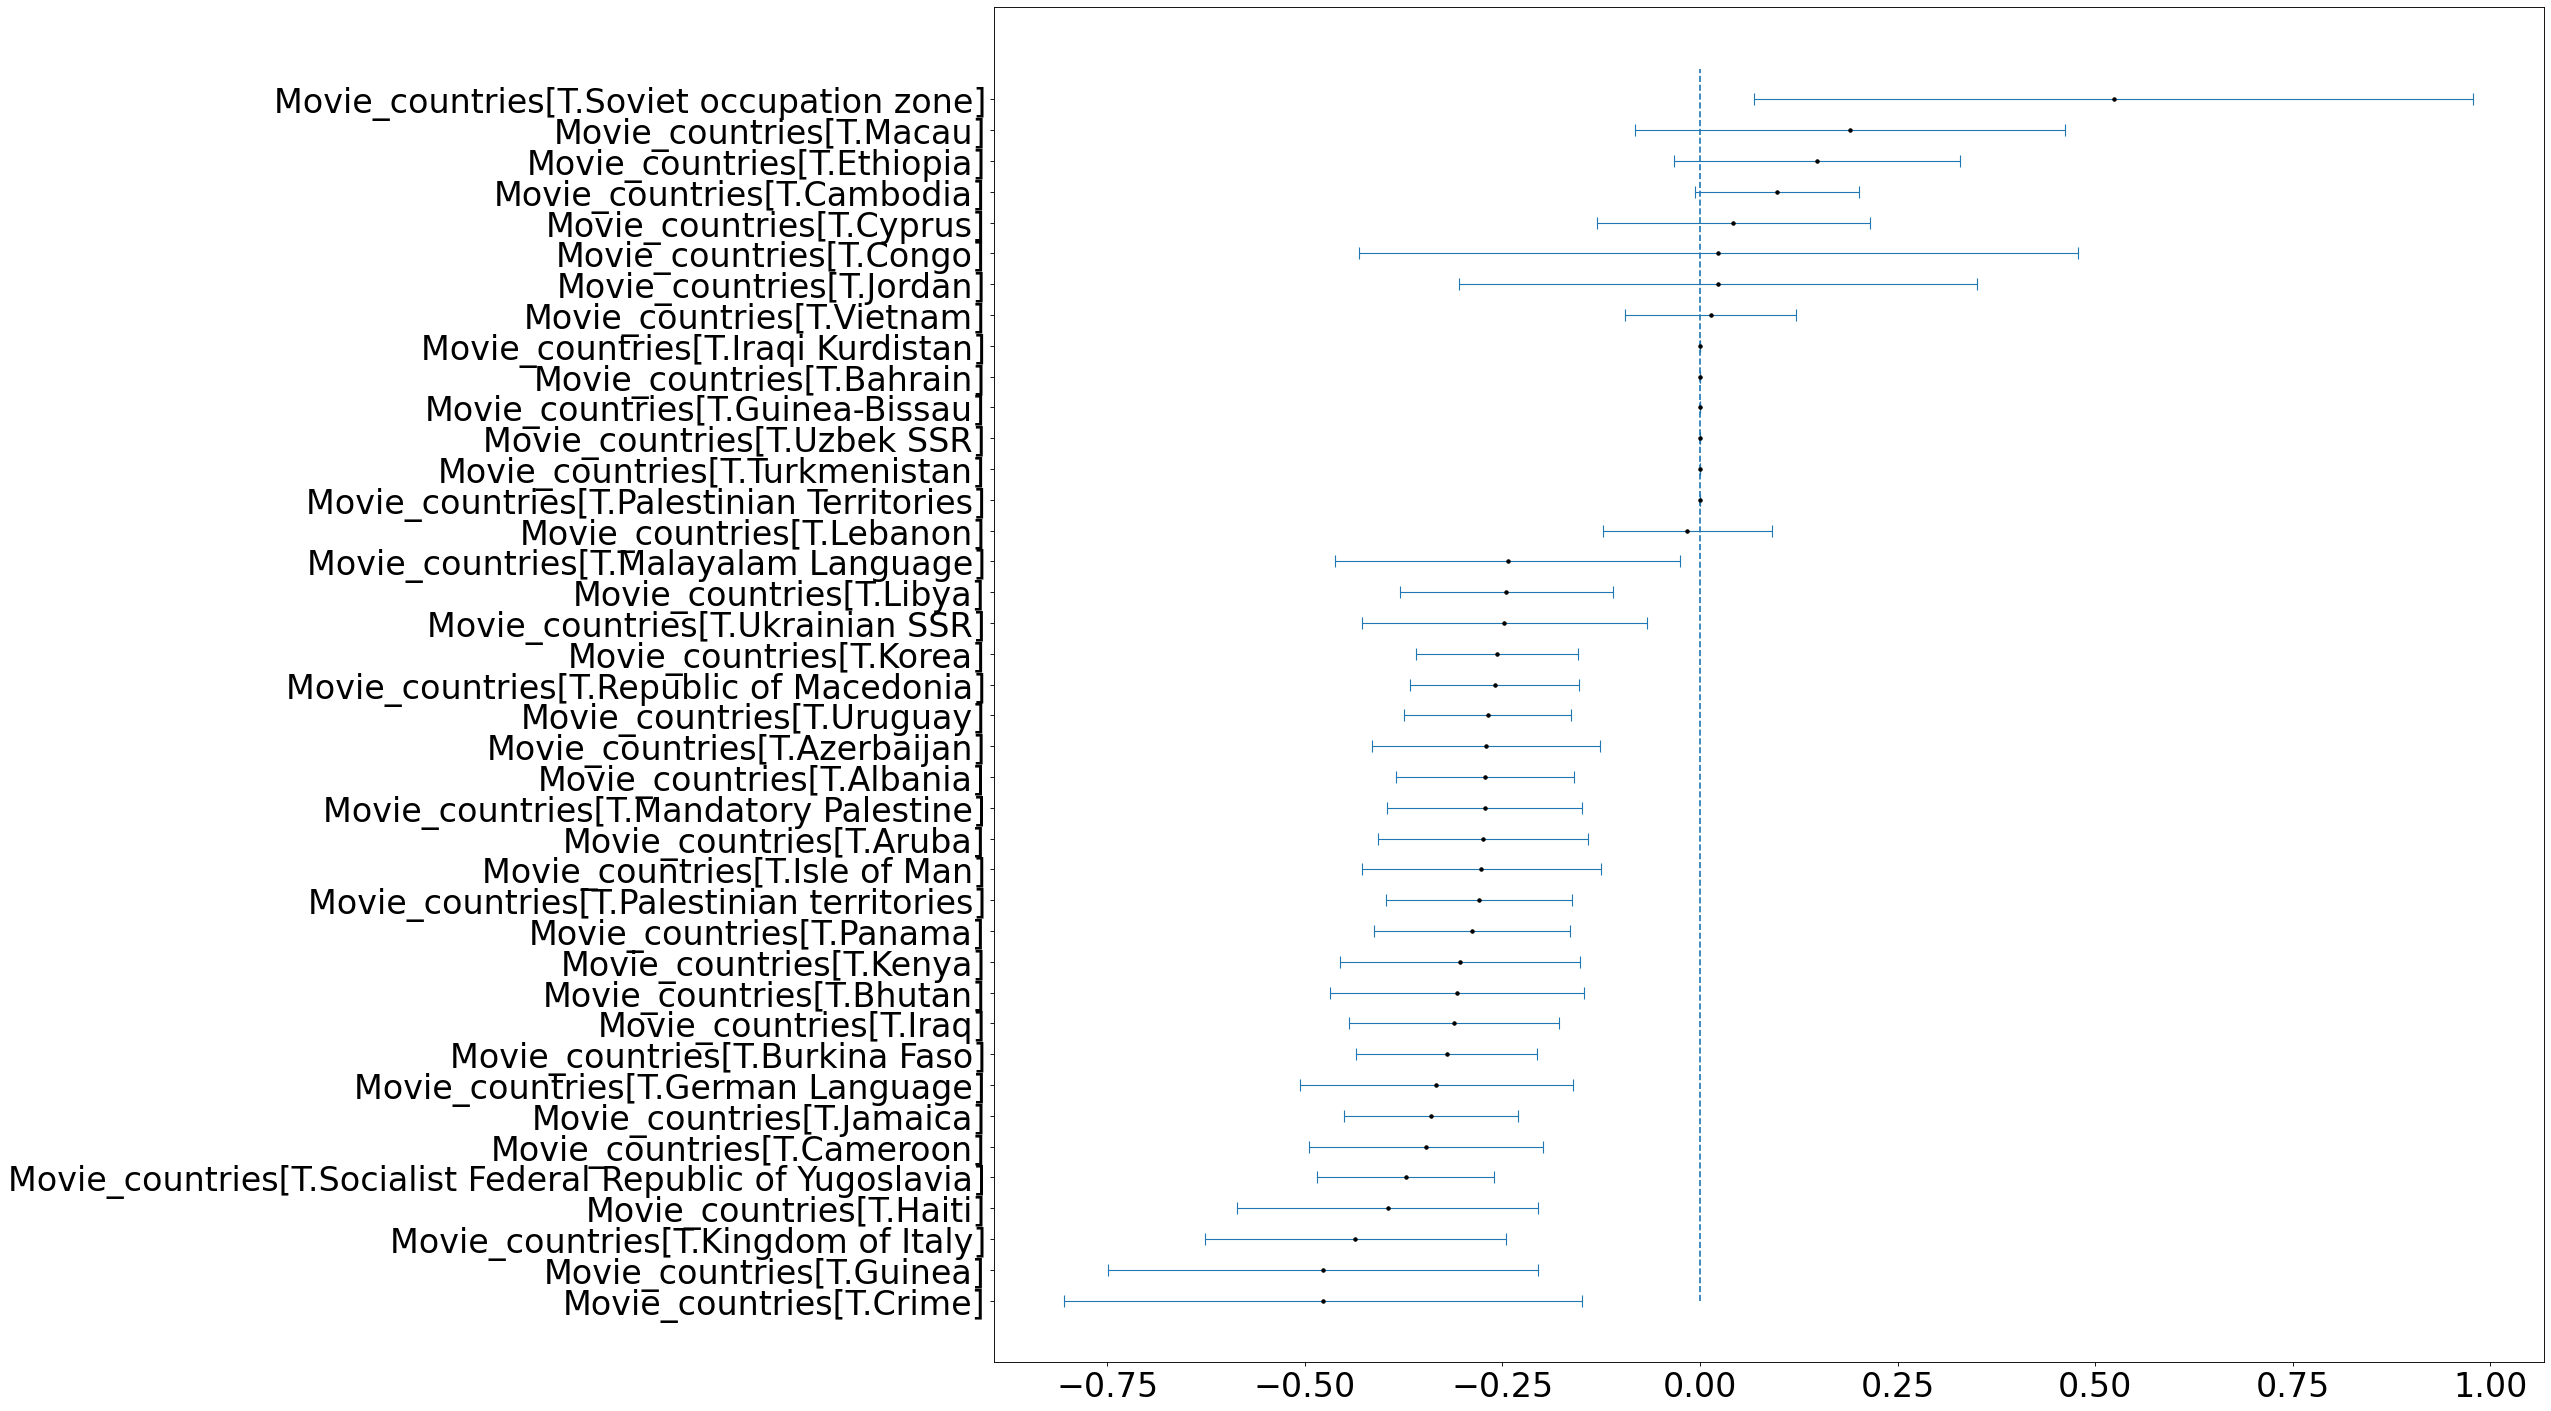

In [226]:
#fancy plotting

figure(figsize=(25, 22), dpi=80)

plt.errorbar(l1_countries, np.array(range(len(l1_countries))), xerr= 2*np.array(l3_countries), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1_countries), linestyle = '--')

plt.yticks(range(len(l2_countries)),l2_countries);

BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Looking at boxoffice revenue and movie runtime

In [227]:
#Linear regression
mod = smf.ols(formula = 'Female_share ~ Movie_boxoffice_revenue + Movie_runtime', data = df_regression)
#mod = smf.ols(formula = 'Female_share ~ Movie_genres', data = df_regression)
res = mod.fit()
results = res.summary()


In [228]:
print(results)

                            OLS Regression Results                            
Dep. Variable:           Female_share   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     267.4
Date:                Fri, 09 Dec 2022   Prob (F-statistic):          2.59e-116
Time:                        16:28:27   Log-Likelihood:                 20982.
No. Observations:               57786   AIC:                        -4.196e+04
Df Residuals:                   57783   BIC:                        -4.193e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [229]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()

,0,1
Intercept,3.675953e-01,3.807331e-01
Movie_boxoffice_revenue,-9.188160e-11,-7.043883e-11
Movie_runtime,-4.975552e-04,-3.768109e-04


In [230]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

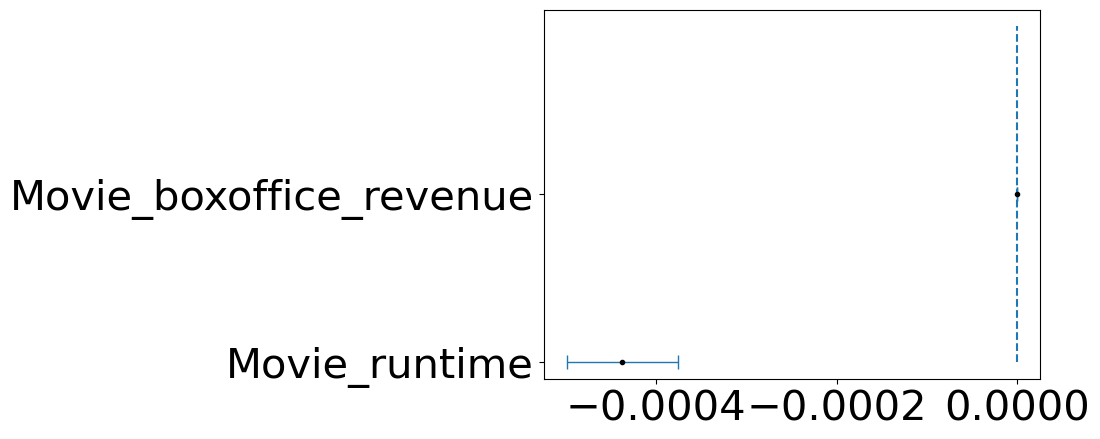

In [231]:
#fancy plotting

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

Movie runtime and box_office_revenue are not significant to determine the female_share